## 1. Business problem/Real-world Problem

> **1.1 What is ELO?**

It is one of the biggest and most reliable payment brands in Brazil. It planned a reward program to attract customers. So, the frequency of using their payment brand has increased.


> **1.2 What is a loyalty Score?**

Loyalty is a numerical score calculated 2 months after the historical and evaluation period. It acts as a target feature in our training data.

> **1.3 Problem Statement**

Elo merchant category recommendation problem talks about the customer loyalty of credit cards for their users in Elo. In Brazil, it is one of the biggest and most reliable payment brands. This reward program is planned by the owners of a company to attract customers. So, the frequency of using their payment brand has increased. Basically, these programs make the customer’s choice more strongly towards the usage of Elo. It is also necessary that policies made by the companies are known to his customers. Here we have the loyalty score which is a numerical score calculated 2 months after the historical and evaluation period.

> **1.4 Real-world/Business objectives and constraints**

Here we predict loyalty scores to help the customers and also it helps reduce the unwanted campaign for Elo.
Here we use RMSE(Root-mean-square-error) for reducing the difference between predicted and actual rating(Regression problem).

## 2. Source of Data


Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key. Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. This is where you come in.

> **2.1 Data Overview:**

We have 6 dataset files for this problem. All the files are in CSV format.

* **Historical_transactions:** Contains up to 3 months of transactions for every card at any of the provided merchant_id’s.
* **Merchant:** contains the aggregate information for each merchant_id represented in the dataset.
* **New_merchant_transactions:** contains the transactions at new merchants(merchant_ids that this particular card_id has not yet visited) over a period of two months.
* **Userscore:** Contains 6 features, which is first_active_month, card_id, feature_1, feature_2, feature_3 and target.

> **What is a loyalty Score?** 

Loyalty is a numerical score calculated 2 months after the historical and evaluation period. It acts as a target feature in our training data.

### Question 1 

> **Q1.** Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction. Note, this is a very important question, you may want to update your whole pipeline multiple times to find the best usage of three files.

To create a single data frame that merges all four tables, we will follow these steps:

1. Concatenate the historical and numerical transaction tables.
2. Inner merge the concatenated table with the user score table.
3. Left merge the resulting table with the merchant table.

In more detail, the first step will combine the historical and numerical transaction tables into a single table. The second step will then merge this table with the user score table, keeping only the rows that exist in both tables. The third step will then merge the resulting table with the merchant table, keeping all of the rows from the first table and adding any new rows from the merchant table.

This process will create a single data frame that contains all of the data from the four original tables. This data frame can then be used for further analysis or visualization.

## Let's Start

In [2]:
!pip install -U yellowbrick

  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)


In [1]:
# import libraries
import pandas as pd
# use the following to suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import plotly.graph_objects as go


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None

In [2]:
# Import libraries

import plotly.express as px
import missingno as msno
from scipy.stats import skew, norm
from scipy import stats
from sklearn.model_selection import train_test_split
# from yellowbrick.regressor import ResidualsPlot


# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.options.display.width = None

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


In [5]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

## Load Data

In [29]:
def reduce_memory_usage(df, verbose=True):
  '''
  This function reduces the memory sizes of dataframe by changing the datatypes of the columns.
  Parameters
  df - DataFrame whose size to be reduced
  verbose - Boolean, to mention the verbose required or not.
  '''
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [9]:
# Importing gc module
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
collected

43

In [28]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_userscore = pd.read_csv('userscore.csv')  # User Score
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')
df_merchant = pd.read_csv('merchants.csv')

In [30]:
df_userscore = reduce_memory_usage( pd.read_csv('userscore.csv'))
df_hist_trans = reduce_memory_usage(pd.read_csv('historical_transactions.csv'))
df_new_merchant_trans = reduce_memory_usage(pd.read_csv('new_merchant_transactions.csv'))
df_merchant = reduce_memory_usage(pd.read_csv('merchants.csv'))

Mem. usage decreased to  5.20 Mb (43.7% reduction)
Mem. usage decreased to 2026.75 Mb (34.8% reduction)
Mem. usage decreased to 136.66 Mb (34.8% reduction)
Mem. usage decreased to 39.90 Mb (29.0% reduction)


## Exploar Data

In [8]:
df_userscore.info()
df_new_merchant_trans.info()
df_hist_trans.info()
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   card_id             201917 non-null  object 
 1   first_active_month  201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   score               201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  


In [9]:
df_userscore.head()
df_new_merchant_trans.head()
df_hist_trans.head()
df_merchant.head()

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820
1,C_ID_3d0044924f,Jan-17,4,1,0,0.393
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.160


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.558,2018-03-11 14:57:36,1.000,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.570,2018-03-19 18:53:37,1.000,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551,2018-04-26 14:08:44,1.000,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.672,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.660,2018-03-22 21:07:53,NaN,-1,29


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703,2017-06-25 15:33:07,1.000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733,2017-07-15 12:10:45,1.000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720,2017-08-09 22:04:29,1.000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735,2017-09-02 10:06:26,1.000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.723,2017-03-10 01:14:19,1.000,16,37


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057,-0.057,N,E,E,-0.400,...,-2.250,18.667,6,-2.320,13.917,12,N,242,9,1.000
1,M_ID_9339d880ad,3184,840,20,-0.057,-0.057,N,E,E,-0.720,...,-0.740,1.292,6,-0.570,1.688,12,N,22,16,1.000
2,M_ID_e726bbae1e,447,690,1,-0.057,-0.057,N,E,E,-82.130,...,-82.130,260.000,2,-82.130,260.000,2,N,-1,5,5.000
3,M_ID_a70e9c5f81,5026,792,9,-0.057,-0.057,Y,E,E,NaN,...,NaN,4.667,6,NaN,3.833,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057,-0.057,Y,E,E,NaN,...,NaN,0.361,6,NaN,0.347,12,Y,-1,-1,NaN


### Check Intersection between tables

In [6]:
common_values = set(df_userscore['card_id']).intersection(set(df_new_merchant_trans['card_id']))

# Count number of occurrences of common values in Column1
common_values_count_Column1 = df_userscore[df_userscore['card_id'].isin(common_values)]['card_id'].value_counts().sum()

# Count number of occurrences of common values in Column2
common_values_count_Column2 = df_new_merchant_trans[df_new_merchant_trans['card_id'].isin(common_values)]['card_id'].value_counts().sum()

# Display results
print("Number of common IDs:", len(common_values))
print("Number of occurrences of common IDs in df_userscore:", common_values_count_Column1)
print("Number of occurrences of common IDs in df_new_merchant_trans:", common_values_count_Column2)

Number of common IDs: 179986
Number of occurrences of common IDs in df_userscore: 179986
Number of occurrences of common IDs in df_new_merchant_trans: 1219685


In [7]:
common_values = set(df_userscore['card_id']).intersection(set(df_hist_trans['card_id']))

# Count number of occurrences of common values in Column1
common_values_count_Column1 = df_userscore[df_userscore['card_id'].isin(common_values)]['card_id'].value_counts().sum()

# Count number of occurrences of common values in Column2
common_values_count_Column2 = df_hist_trans[df_hist_trans['card_id'].isin(common_values)]['card_id'].value_counts().sum()

# Display results
print("Number of common IDs:", len(common_values))
print("Number of occurrences of common IDs in df_userscore:", common_values_count_Column1)
print("Number of occurrences of common IDs in df_hist_trans:", common_values_count_Column2)

Number of common IDs: 201917
Number of occurrences of common IDs in df_userscore: 201917
Number of occurrences of common IDs in df_hist_trans: 18030009


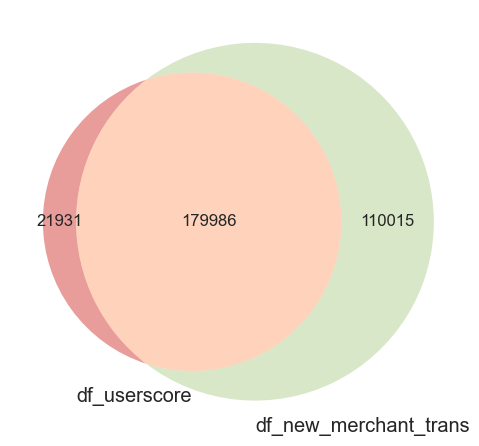

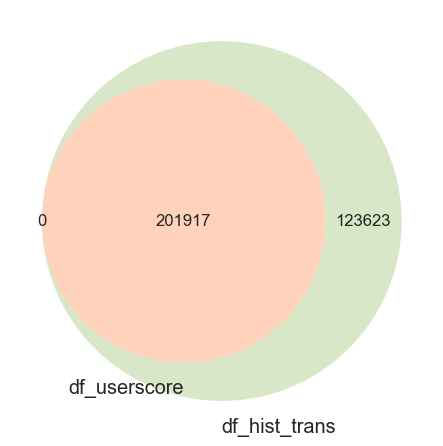

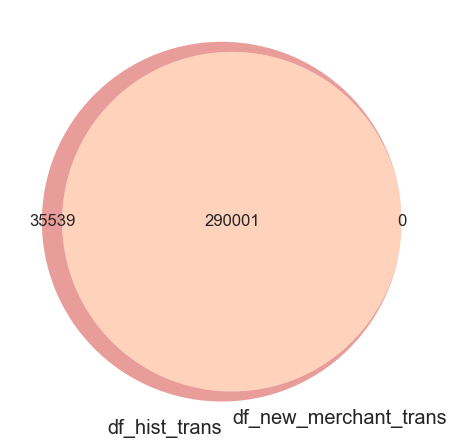

In [33]:
venn2([set(df_userscore['card_id']), set(df_new_merchant_trans['card_id'])],set_labels = ('df_userscore','df_new_merchant_trans'))
plt.show()


venn2([set(df_userscore['card_id']), set(df_hist_trans['card_id'])],set_labels = ('df_userscore','df_hist_trans'))
plt.show()


venn2([set(df_hist_trans['card_id']), set(df_new_merchant_trans['card_id'])],set_labels = ('df_hist_trans','df_new_merchant_trans'))
plt.show()

C:\Users\Lap-5\anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


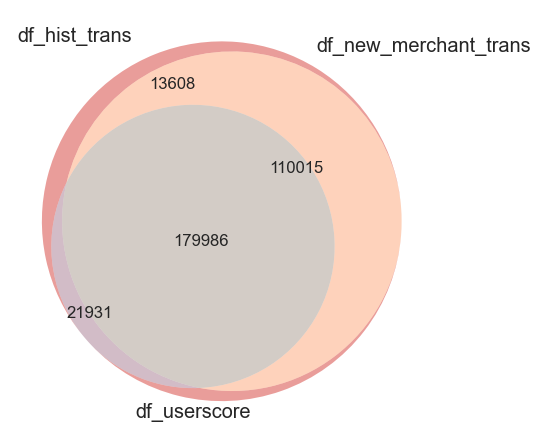

In [34]:
venn3([set(df_hist_trans['card_id']), set(df_new_merchant_trans['card_id']),set(df_userscore['card_id'])],set_labels = ('df_hist_trans','df_new_merchant_trans','df_userscore'))
plt.show()

> **So we can see that not all user in the transaction data exist in the user score data**

### Check Null Values

#### For df_userscore

In [10]:
missing_columns = df_userscore.isnull().sum()
missing_columns[missing_columns>0].sort_values(ascending=False)

Series([], dtype: int64)

#### For df_hist_trans

In [11]:
missing_columns = df_hist_trans.isnull().sum()
missing_columns[missing_columns>0].sort_values(ascending=False)

category_2     2652864
category_3      178159
merchant_id     138481
dtype: int64

In [12]:
missing_values = missing_columns[missing_columns>0]
# Get the total number of rows in the DataFrame
total_rows = df_hist_trans.shape[0]

# Calculate the percentage of missing values for each column
missing_percentage = missing_values / total_rows

# Sort the missing values by the percentage of missing values
missing_percentage.sort_values(ascending=False, inplace=True)

# # Print the top-3 most missed columns
# top_3_missing_columns = missing_percentage.head(3)

# Print the percentage of missing values for each column
for column in missing_percentage.index:
    print(column, "{0:.2%}".format(missing_percentage[column]))

# # Describe the columns
# for column in top_3_missing_columns.index:
#     print(all_data[column].describe())

category_2 9.11%
category_3 0.61%
merchant_id 0.48%


<AxesSubplot:>

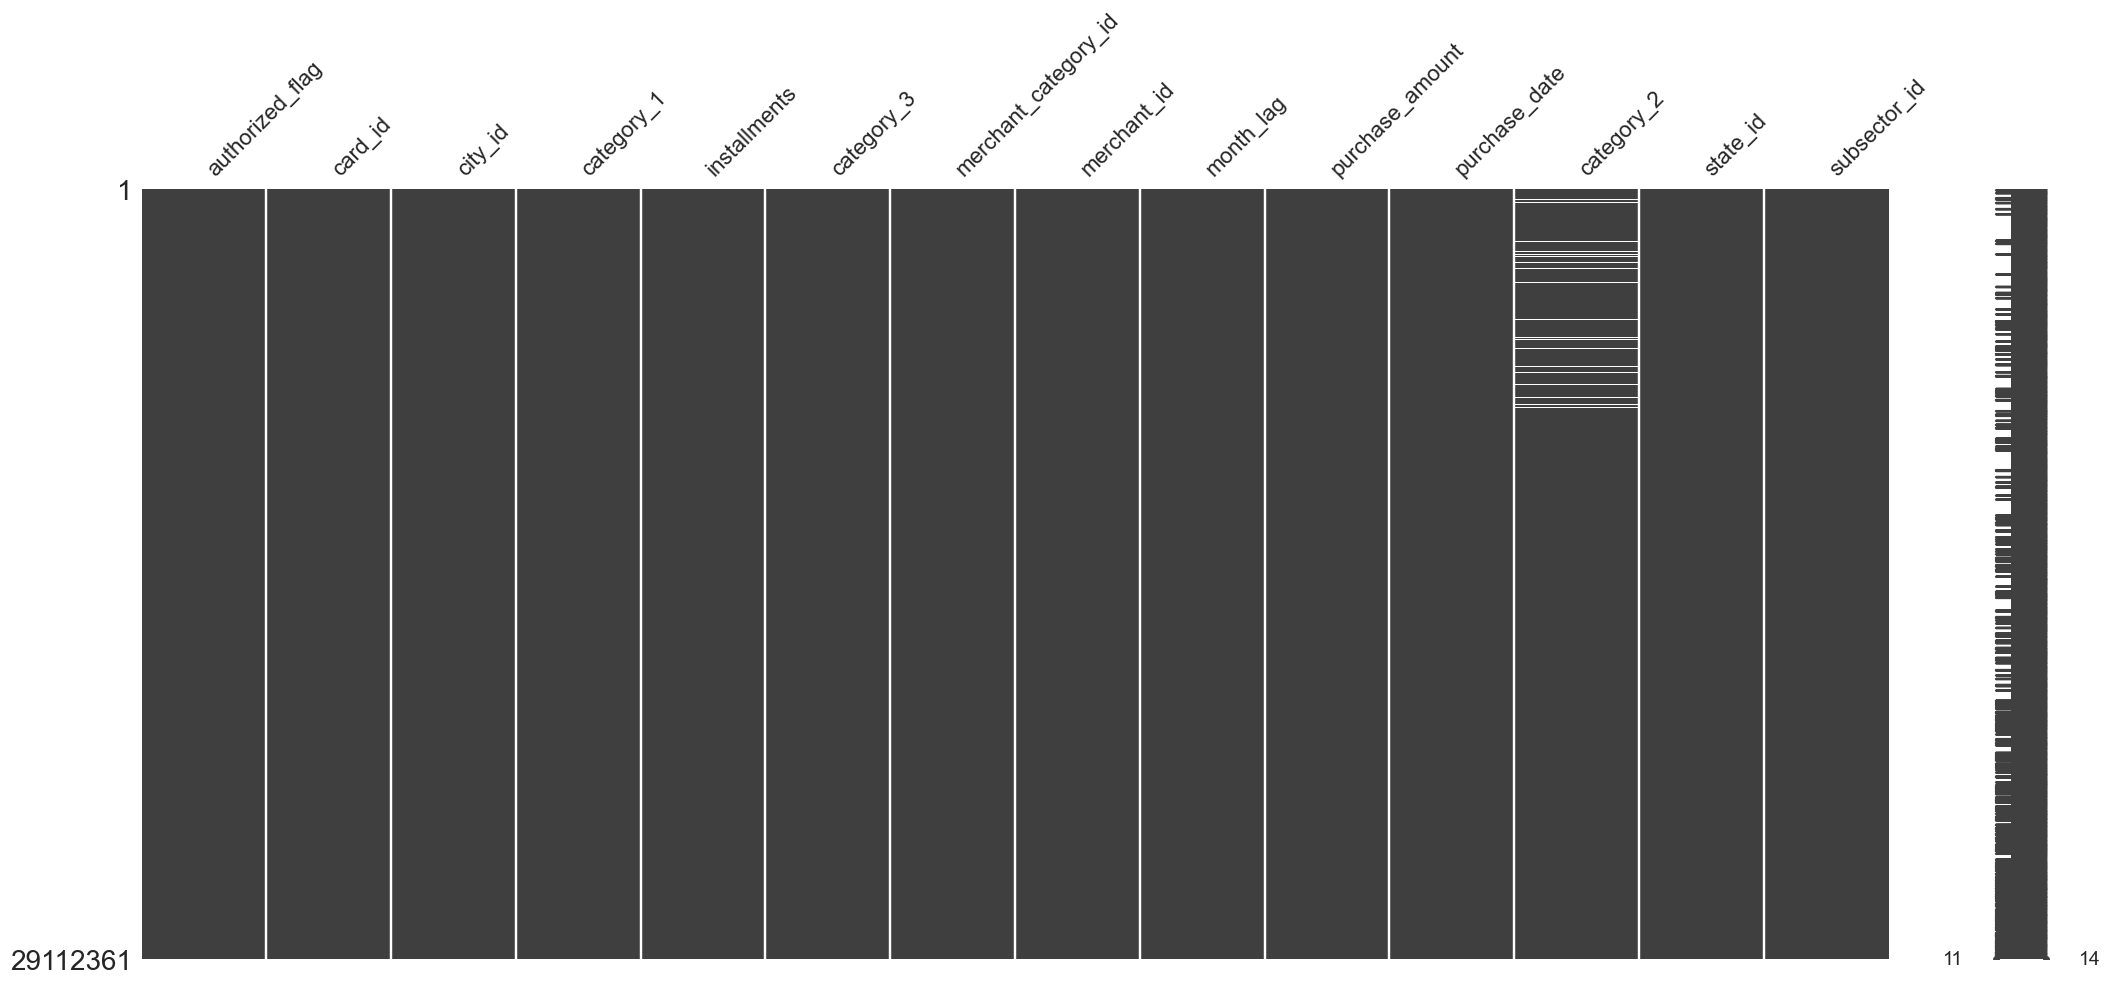

In [13]:
msno.matrix(df_hist_trans)

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|0.48%| |MCAR|Object|Drop Null Values |
|category_3|0.61%| |MCAR|Object|Most Frequent |
|category_2|9.11%||MCAR|Object|Most Frequent |

#### For df_new_merchant_trans

In [16]:
missing_columns = df_new_merchant_trans.isnull().sum()
missing_columns[missing_columns>0].sort_values(ascending=False)

category_2     111745
category_3      55922
merchant_id     26216
dtype: int64

In [17]:
missing_values = missing_columns[missing_columns>0]
# Get the total number of rows in the DataFrame
total_rows = df_new_merchant_trans.shape[0]

# Calculate the percentage of missing values for each column
missing_percentage = missing_values / total_rows

# Sort the missing values by the percentage of missing values
missing_percentage.sort_values(ascending=False, inplace=True)

# # Print the top-3 most missed columns
# top_3_missing_columns = missing_percentage.head(3)

# Print the percentage of missing values for each column
for column in missing_percentage.index:
    print(column, "{0:.2%}".format(missing_percentage[column]))

# # Describe the columns
# for column in top_3_missing_columns.index:
#     print(all_data[column].describe())

category_2 5.69%
category_3 2.85%
merchant_id 1.34%


<AxesSubplot:>

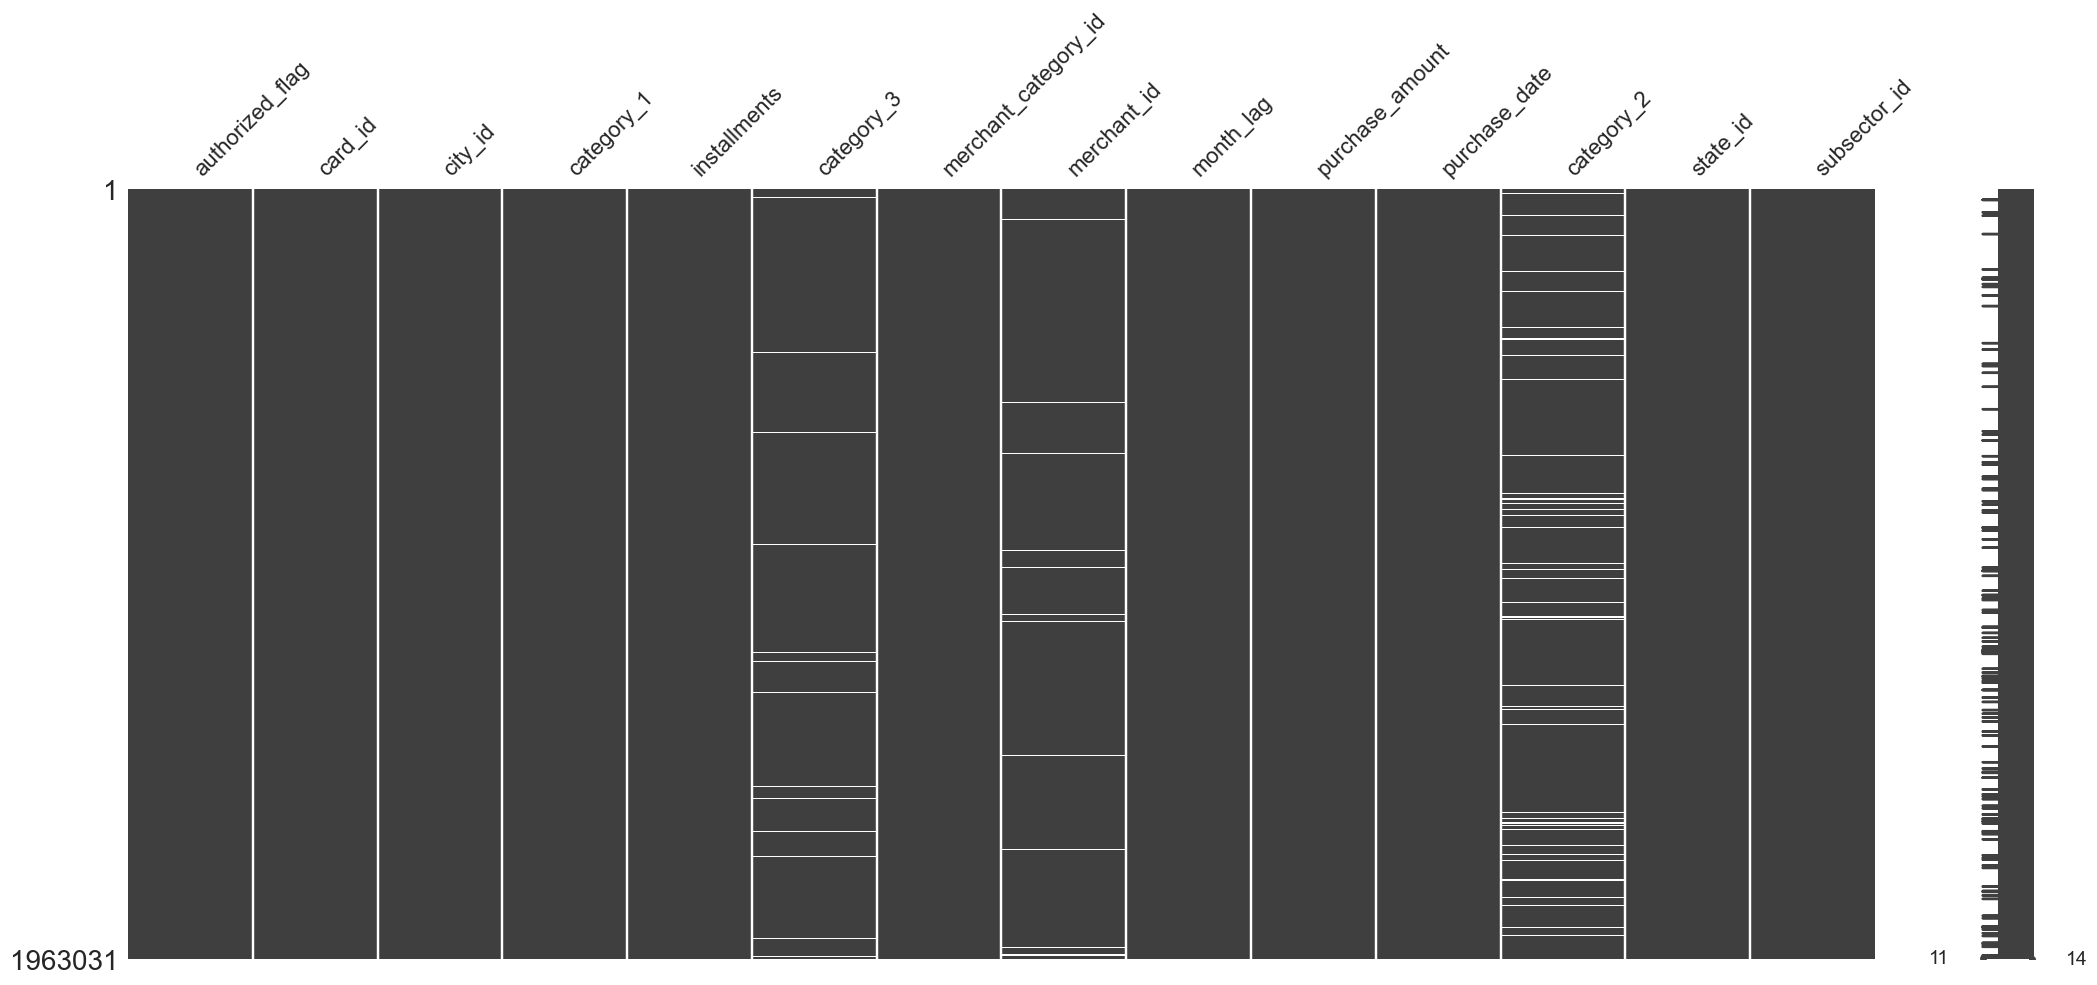

In [18]:
msno.matrix(df_new_merchant_trans)

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|1.34%| |MCAR|Object|Drop Null Values |
|category_3|2.85%| |MCAR|Object|Most Frequent |
|category_2|5.69%||MCAR|Object|Most Frequent |

#### For df_merchant

In [20]:
missing_columns = df_merchant.isnull().sum()
missing_columns[missing_columns>0].sort_values(ascending=False)

category_2         11887
avg_sales_lag3        13
avg_sales_lag6        13
avg_sales_lag12       13
dtype: int64

In [21]:
missing_values = missing_columns[missing_columns>0]
# Get the total number of rows in the DataFrame
total_rows = df_new_merchant_trans.shape[0]

# Calculate the percentage of missing values for each column
missing_percentage = missing_values / total_rows

# Sort the missing values by the percentage of missing values
missing_percentage.sort_values(ascending=False, inplace=True)

# # Print the top-3 most missed columns
# top_3_missing_columns = missing_percentage.head(3)

# Print the percentage of missing values for each column
for column in missing_percentage.index:
    print(column, "{0:.2%}".format(missing_percentage[column]))

# # Describe the columns
# for column in top_3_missing_columns.index:
#     print(all_data[column].describe())

category_2 0.61%
avg_sales_lag3 0.00%
avg_sales_lag6 0.00%
avg_sales_lag12 0.00%


<AxesSubplot:>

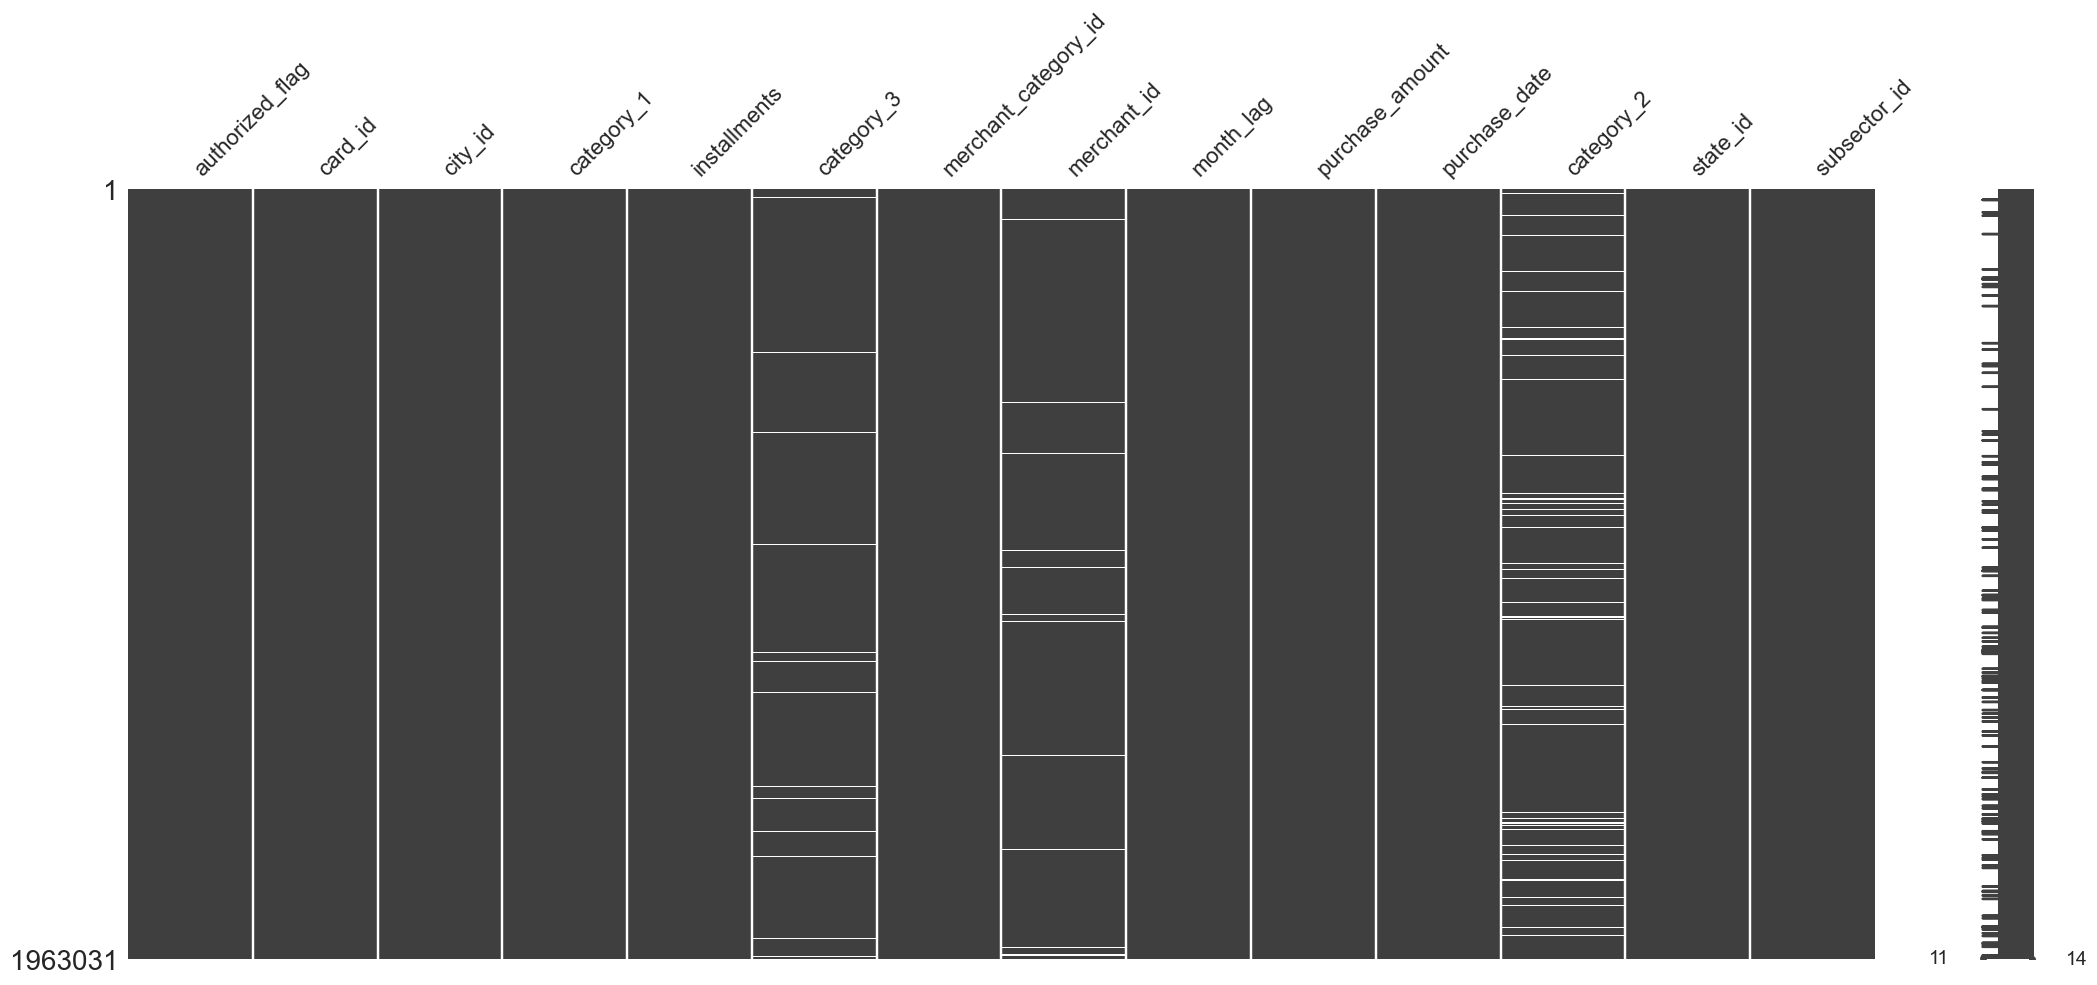

In [22]:
msno.matrix(df_merchant)

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|avg_sales_lag12 |0.00%| |MCAR|Object|Mean |
|avg_sales_lag6 |0.00%| |MCAR|Object|Mean|
|avg_sales_lag3 |0.00%| |MCAR|Object|Mean|
|category_2|0.61%||MCAR|Object|Most Frequent |

### Question 2 

> **Q2.** Discuss the quality of the dataset, considering missing values, missing value patterns, missing value mechanism, and noise (e.g., consistency). Note, you do not need to discuss each attribute in each table. Focus on the ones you believe are the most important for user (card) loyalty analysis and prediction.

> **From above we can see that the three tables hist_trans,new_merchant_trans,merchant all of them have null values in some columns** 

#### 1. For df_hist_trans

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|0.48%|General Pattern |MCAR|Object|Drop Null Values |
|category_3|0.61%|General Pattern |MCAR|Object|Most Frequent |
|category_2|9.11%|General Pattern|MCAR|Object|Most Frequent |


#### 2. For df_new_merchant_trans

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|1.34%|General Pattern |MCAR|Object|Drop Null Values |
|category_3|2.85%|General Pattern |MCAR|Object|Most Frequent |
|category_2|5.69%|General Pattern|MCAR|Object|Most Frequent |


#### 3. For df_merchant

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|avg_sales_lag12 |0.00%|General Pattern |MCAR|Object|Mean |
|avg_sales_lag6 |0.00%|General Pattern |MCAR|Object|Mean|
|avg_sales_lag3 |0.00%|General Pattern |MCAR|Object|Mean|
|category_2|0.61%|General Pattern|MCAR|Object|Most Frequent |


**The above tables descripe the Missing value patterns & Missing value mechanism for the columns that have Null values.**


### check inf values

In [27]:
ds = df_merchant.isin([np.inf, -np.inf])
print(ds.sum())

print('----'*30)

ds = df_hist_trans.isin([np.inf, -np.inf])
print(ds.sum())

print('----'*30)

ds = df_userscore.isin([np.inf, -np.inf])
print(ds.sum())

print('----'*30)

ds = df_new_merchant_trans.isin([np.inf, -np.inf])
print(ds.sum())

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64
------------------------------------------------------------------------------------------------------------------------
authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3

### **Check outliers in the data** 

In [57]:
def has_outliers(df, column):
    first_quartile = df[column].quantile(0.25)
    third_quartile = df[column].quantile(0.75)
    interquartile_range = third_quartile - first_quartile

    # Identify the outliers for the column
    lower = first_quartile - 1.5 * interquartile_range
    upper = third_quartile + 1.5 * interquartile_range
    outliers_data = df[column].loc[(df[column] < lower) | (df[column] > upper)]

    # Check if there are any outliers
    if any(outliers_data):
        # df.loc[outliers_data.index, :] = first_quartile if outliers_data < first_quartile else third_quartile
        print('There are outliers in the {} column count {:,}'.format(column, outliers_data.shape[0]))
    else:
        print('There are no outliers in the {} column'.format(column))

In [1]:

def get_outlier_bounds(df, col_name):
    # Compute the first and third quartiles and the interquartile range
    first_quartile = df[col_name].quantile(0.25)
    third_quartile = df[col_name].quantile(0.75)
    interquartile_range = third_quartile - first_quartile

    # Compute the lower and upper bounds for outliers
    lower = first_quartile - 1.5 * interquartile_range
    upper = third_quartile + 1.5 * interquartile_range
    
    return (lower, upper)

#### For df_userscore

In [24]:
df_userscore.describe()

,feature_1,feature_2,feature_3,score
count,201917.000,201917.000,201917.000,201917.000
mean,3.105,1.745,0.566,-0.394
std,1.186,0.751,0.496,3.850
min,1.000,1.000,0.000,-33.219
25%,2.000,1.000,0.000,-0.883
50%,3.000,2.000,1.000,-0.023
75%,4.000,2.000,1.000,0.765
max,5.000,3.000,1.000,17.965


In [26]:
num_cols = df_userscore.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in num_cols:
    has_outliers(df_userscore, column)

There are no outliers in the feature_1 column
There are no outliers in the feature_2 column
There are no outliers in the feature_3 column
There are outliers in the score column count 15,397


In [15]:
high_positave  = df_userscore[(df_userscore['score'] >= 1)]
low_negative  = df_userscore[(df_userscore['score'] < -1)]

percentageNeg = (low_negative.shape[0] / df_userscore.shape[0]) 
percentagePos = (high_positave.shape[0] / df_userscore.shape[0]) 

print('Percentage of data that is higher than 1  is {0:.2%}'.format(percentagePos))
print('Percentage of data that is lower than -1 is {0:.2%}'.format(percentageNeg))


Percentage of data that is higher than 1  is 20.31%
Percentage of data that is lower than -1 is 22.61%


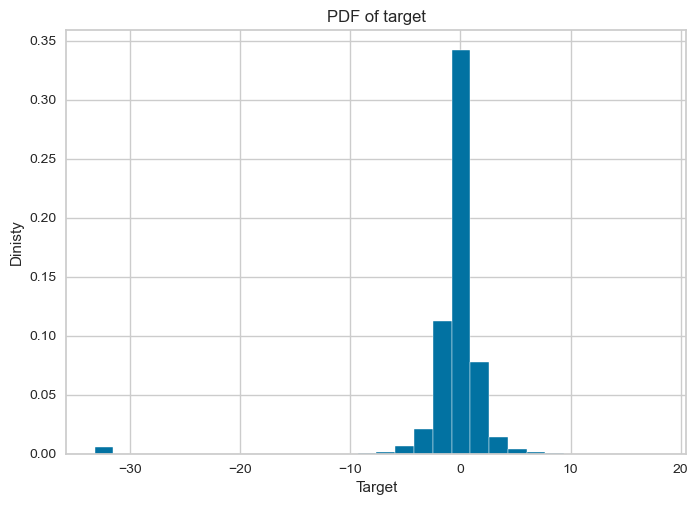

In [25]:
# generate a histogram of the 'age' column
fig = plt.hist(df_userscore['score'],density=True, bins=30)
x = plt.xlabel('Target')
x = plt.ylabel('Dinisty')
x = plt.title('PDF of target')
plt.show()

#### For df_hist_trans

In [27]:
df_hist_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,29112361.000,29112361.000,29112361.000,29112361.000,29112361.000,26459497.000,29112361.000,29112361.000
mean,129.326,0.648,481.013,-4.487,0.036,2.195,10.567,26.848
std,104.256,2.796,249.376,3.589,1123.522,1.532,6.367,9.693
min,-1.000,-1.000,-1.000,-13.000,-0.747,1.000,-1.000,-1.000
25%,53.000,0.000,307.000,-7.000,-0.720,1.000,9.000,19.000
50%,90.000,0.000,454.000,-4.000,-0.688,1.000,9.000,29.000
75%,212.000,1.000,705.000,-2.000,-0.603,3.000,16.000,34.000
max,347.000,999.000,891.000,0.000,6010603.972,5.000,24.000,41.000


In [12]:
num_cols = df_hist_trans.select_dtypes(include=['int8','int16','int64', 'float64']).columns.tolist()
for column in num_cols:
    has_outliers(df_hist_trans, column)

There are no outliers in the city_id column
There are outliers in the installments column count 1,178,517
There are no outliers in the merchant_category_id column
There are no outliers in the month_lag column
There are outliers in the purchase_amount column count 2,907,482
There are no outliers in the category_2 column
There are no outliers in the state_id column
There are no outliers in the subsector_id column


<Figure size 2000x1000 with 0 Axes>

<AxesSubplot:>

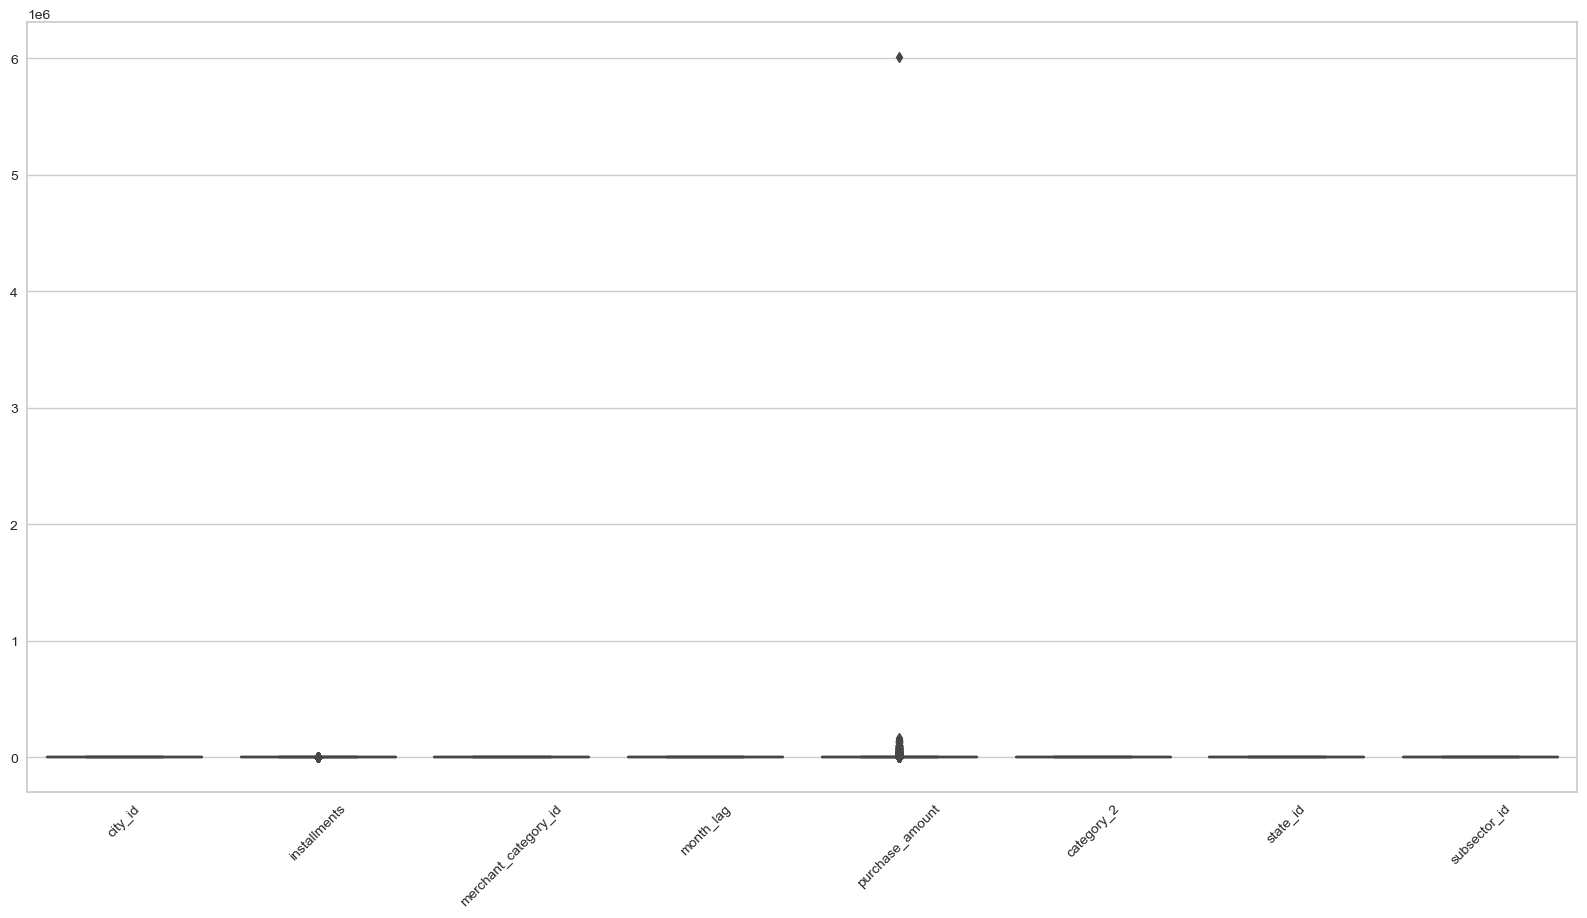

In [54]:

plt.figure(figsize=(20,10))

sns.boxplot(data=df_hist_trans)
x = plt.xticks(rotation=45)


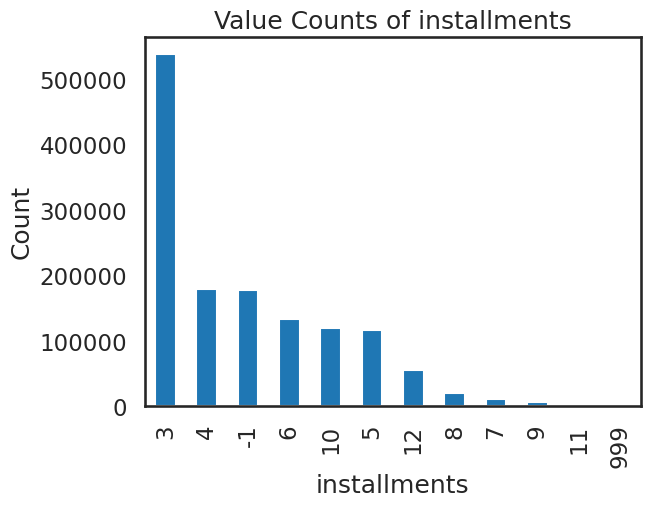

In [22]:
low_negative  = df_hist_trans[(df_hist_trans['installments'] > 2.5)|(df_hist_trans['installments'] <0 )]

# Assuming df_new_merchant_trans is your pandas dataframe
installments_vc = low_negative.installments.value_counts()
installments_vc.plot.bar()
plt.xlabel('installments')
plt.ylabel('Count')
plt.title('Value Counts of installments')
plt.show()

> **What we will do with insatllments = 999? We will replace it with 11**

> **What we will do with insatllments = -1? the may indcation that the user did not his last insallment**

#### For df_new_merchant_trans

In [30]:
df_new_merchant_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,1963031.000,1963031.000,1963031.000,1963031.000,1963031.000,1851286.000,1963031.000,1963031.000
mean,134.387,0.683,430.970,1.477,-0.551,2.198,10.881,25.976
std,101.515,1.584,246.339,0.499,0.694,1.528,6.039,10.129
min,-1.000,-1.000,-1.000,1.000,-0.747,1.000,-1.000,-1.000
25%,69.000,0.000,278.000,1.000,-0.717,1.000,9.000,19.000
50%,110.000,1.000,367.000,1.000,-0.675,1.000,9.000,29.000
75%,212.000,1.000,683.000,2.000,-0.582,3.000,15.000,34.000
max,347.000,999.000,891.000,2.000,263.157,5.000,24.000,41.000


In [7]:
num_cols = df_new_merchant_trans.select_dtypes(include=['int8','int16','int64', 'float64']).columns.tolist()
for column in num_cols:
    has_outliers(df_new_merchant_trans, column)

There are no outliers in the city_id column
There are outliers in the installments column count 93,958
There are no outliers in the merchant_category_id column
There are no outliers in the month_lag column
There are outliers in the purchase_amount column count 200,708
There are no outliers in the category_2 column
There are outliers in the state_id column count 111,745
There are no outliers in the subsector_id column


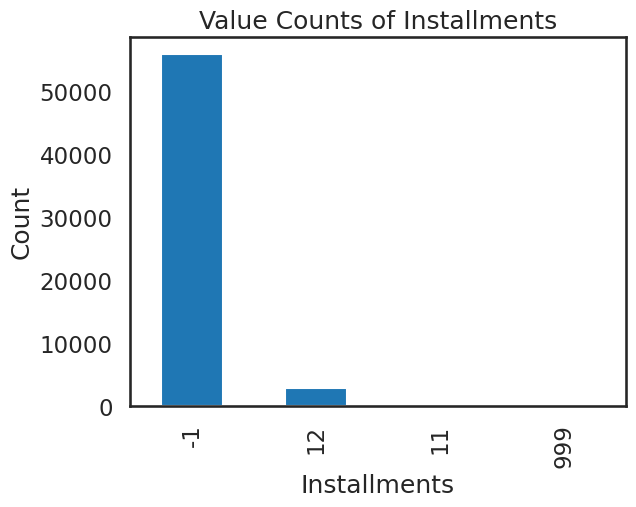

In [79]:
low_negative  = df_new_merchant_trans[(df_new_merchant_trans['installments'] < 0) |(df_new_merchant_trans['installments'] > 10) ]

# Assuming df_new_merchant_trans is your pandas dataframe
installments_vc = low_negative.installments.value_counts()
installments_vc.plot.bar()
plt.xlabel('Installments')
plt.ylabel('Count')
plt.title('Value Counts of Installments')
plt.show()

> **What we will do with insatllments = 999? We will replace it with 11**

> **What we will do with insatllments = -1? the may indcation that the user did not his last insallment**

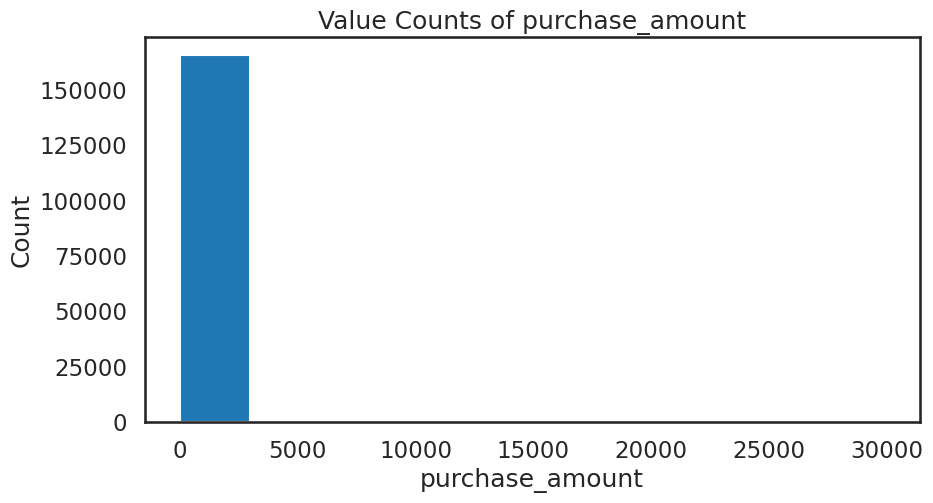

In [30]:
low_negative  = df_hist_trans[(df_hist_trans['purchase_amount'] > 0)]

# Assuming df_new_merchant_trans is your pandas dataframe
purchase_amount_vc = low_negative.purchase_amount.value_counts()
plt.figure(figsize = (10,5))
purchase_amount_vc.plot.hist()
plt.xlabel('purchase_amount')
plt.ylabel('Count')
plt.title('Value Counts of purchase_amount')
plt.show()

> **What we will do with purchase amount higher than 10? We will not change any thing in these columns as higher purchase amount is a real data not just an noise and it have meaning value we do not wont to lose it**

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'purchase_amount')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Value Counts of purchase_amount')

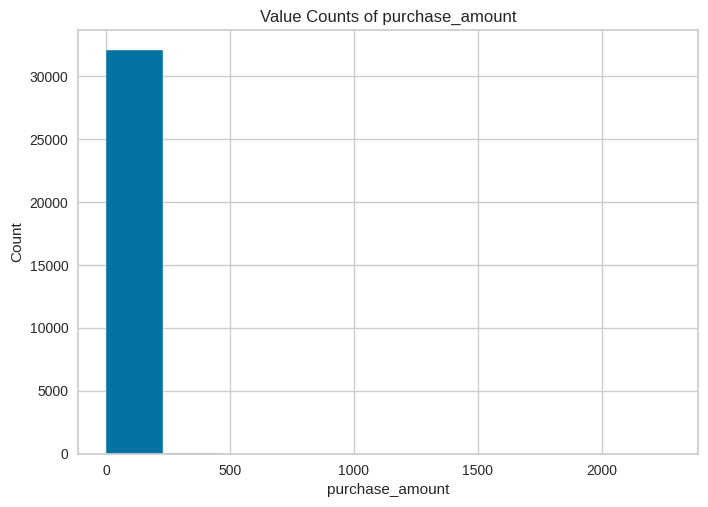

In [6]:
low_negative  = df_new_merchant_trans[(df_new_merchant_trans['purchase_amount'] > 0)  ]

# Assuming df_new_merchant_trans is your pandas dataframe
purchase_amount_vc = low_negative.purchase_amount.value_counts()
purchase_amount_vc.plot.hist()
plt.xlabel('purchase_amount')
plt.ylabel('Count')
plt.title('Value Counts of purchase_amount')
plt.show()

> **What we will do with purchase amount higher than 10? We will not change any thing in these columns as higher purchase amount is a real data not just an nise and it have meaning value we do not wont to lose it**

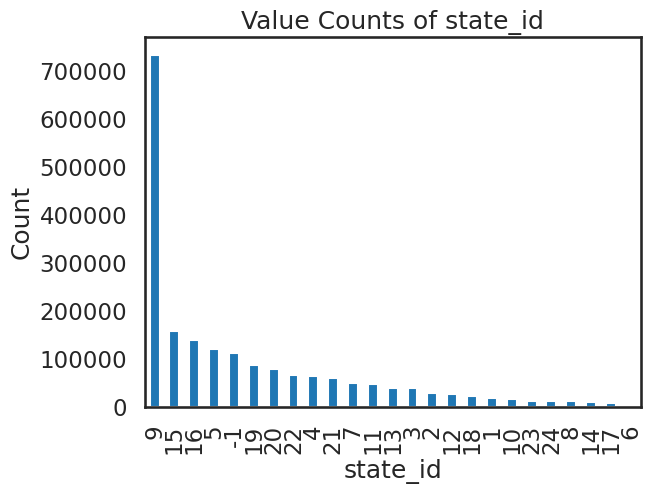

In [111]:
low_negative  = df_new_merchant_trans[(df_new_merchant_trans['state_id'] < 0)  ]

# Assuming df_new_merchant_trans is your pandas dataframe
purchase_amount_vc = df_new_merchant_trans.state_id.value_counts()
purchase_amount_vc.plot.bar()
plt.xlabel('state_id')
plt.ylabel('Count')
plt.title('Value Counts of state_id')
plt.show()

> **What we will do with state id = -1? We will replace it with 0**

#### For df_merchant

In [33]:
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000,334696.000,334696.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334696.000,334696.000,322809.000
mean,31028.736,423.132,25.116,0.011,0.008,13.833,inf,2.994,21.651,inf,5.947,25.228,inf,11.599,102.918,11.861,2.380
std,31623.043,252.898,9.807,1.098,1.070,2395.490,NaN,0.095,3947.108,NaN,0.395,5251.842,NaN,1.520,107.091,6.177,1.563
min,1.000,-1.000,-1.000,-0.057,-0.057,-82.130,0.333,1.000,-82.130,0.167,1.000,-82.130,0.098,1.000,-1.000,-1.000,1.000
25%,3612.000,222.000,19.000,-0.057,-0.057,0.880,0.924,3.000,0.850,0.902,6.000,0.850,0.898,12.000,-1.000,9.000,1.000
50%,19900.000,373.000,27.000,-0.057,-0.057,1.000,1.017,3.000,1.010,1.027,6.000,1.020,1.043,12.000,69.000,9.000,2.000
75%,51707.250,683.000,33.000,-0.048,-0.048,1.160,1.147,3.000,1.230,1.216,6.000,1.290,1.266,12.000,182.000,16.000,4.000
max,112586.000,891.000,41.000,183.735,182.079,851844.640,inf,3.000,1513959.000,inf,6.000,2567408.000,inf,12.000,347.000,24.000,5.000


In [34]:
num_cols = df_merchant.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [35]:
for column in num_cols:
    has_outliers(df_merchant, column)

There are no outliers in the merchant_group_id column
There are no outliers in the merchant_category_id column
There are no outliers in the subsector_id column
There are outliers in the numerical_1 column count 48,691
There are outliers in the numerical_2 column count 41,058
There are outliers in the avg_sales_lag3 column count 36,625
There are outliers in the avg_purchases_lag3 column count 37,533
There are outliers in the active_months_lag3 column count 1,434
There are outliers in the avg_sales_lag6 column count 36,247
There are outliers in the avg_purchases_lag6 column count 36,444
There are outliers in the active_months_lag6 column count 7,412
There are outliers in the avg_sales_lag12 column count 35,809
There are outliers in the avg_purchases_lag12 column count 35,721
There are outliers in the active_months_lag12 column count 29,595
There are no outliers in the city_id column
There are no outliers in the state_id column
There are no outliers in the category_2 column


> **We will not deal with outliears as most of columns that have outliers we will drop it due to high corrolation between them**

### Check Multicollinearity 

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df_hist_trans.dropna()

num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

,variable,VIF
0,city_id,2.728
1,installments,1.039
2,merchant_category_id,3.798
3,month_lag,2.428
4,purchase_amount,1.000
5,category_2,3.027
6,state_id,4.801
7,subsector_id,6.073


In [8]:
# import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df_merchant.dropna()

num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

,variable,VIF
0,merchant_group_id,1.994
1,merchant_category_id,3.789
2,subsector_id,7.647
3,numerical_1,399.809
4,numerical_2,399.788
5,avg_sales_lag3,45.882
6,avg_purchases_lag3,398.562
7,active_months_lag3,535.552
8,avg_sales_lag6,252.026
9,avg_purchases_lag6,1603.937


From above we will need to drope data that have high VIF value, We will take threshold higher than 10 : 
* numerical_1 
* numerical_2 
* avg_sales_lag3 
* avg_purchases_lag3 
* active_months_lag3 
* avg_sales_lag6
* avg_purchases_lag6
* active_months_lag6
* avg_sales_lag12
* avg_purchases_lag12
* active_months_lag12

In [9]:
# import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df_userscore.dropna()
num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

,variable,VIF
0,feature_1,5.757
1,feature_2,3.390
2,feature_3,3.391
3,score,1.011


In [10]:
# import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df_new_merchant_trans.dropna()

num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

,variable,VIF
0,city_id,2.828
1,installments,1.247
2,merchant_category_id,3.481
3,month_lag,6.917
4,purchase_amount,2.025
5,category_2,3.039
6,state_id,4.903
7,subsector_id,5.998


### Check Corrolation

<Figure size 3000x1000 with 0 Axes>

<AxesSubplot:>

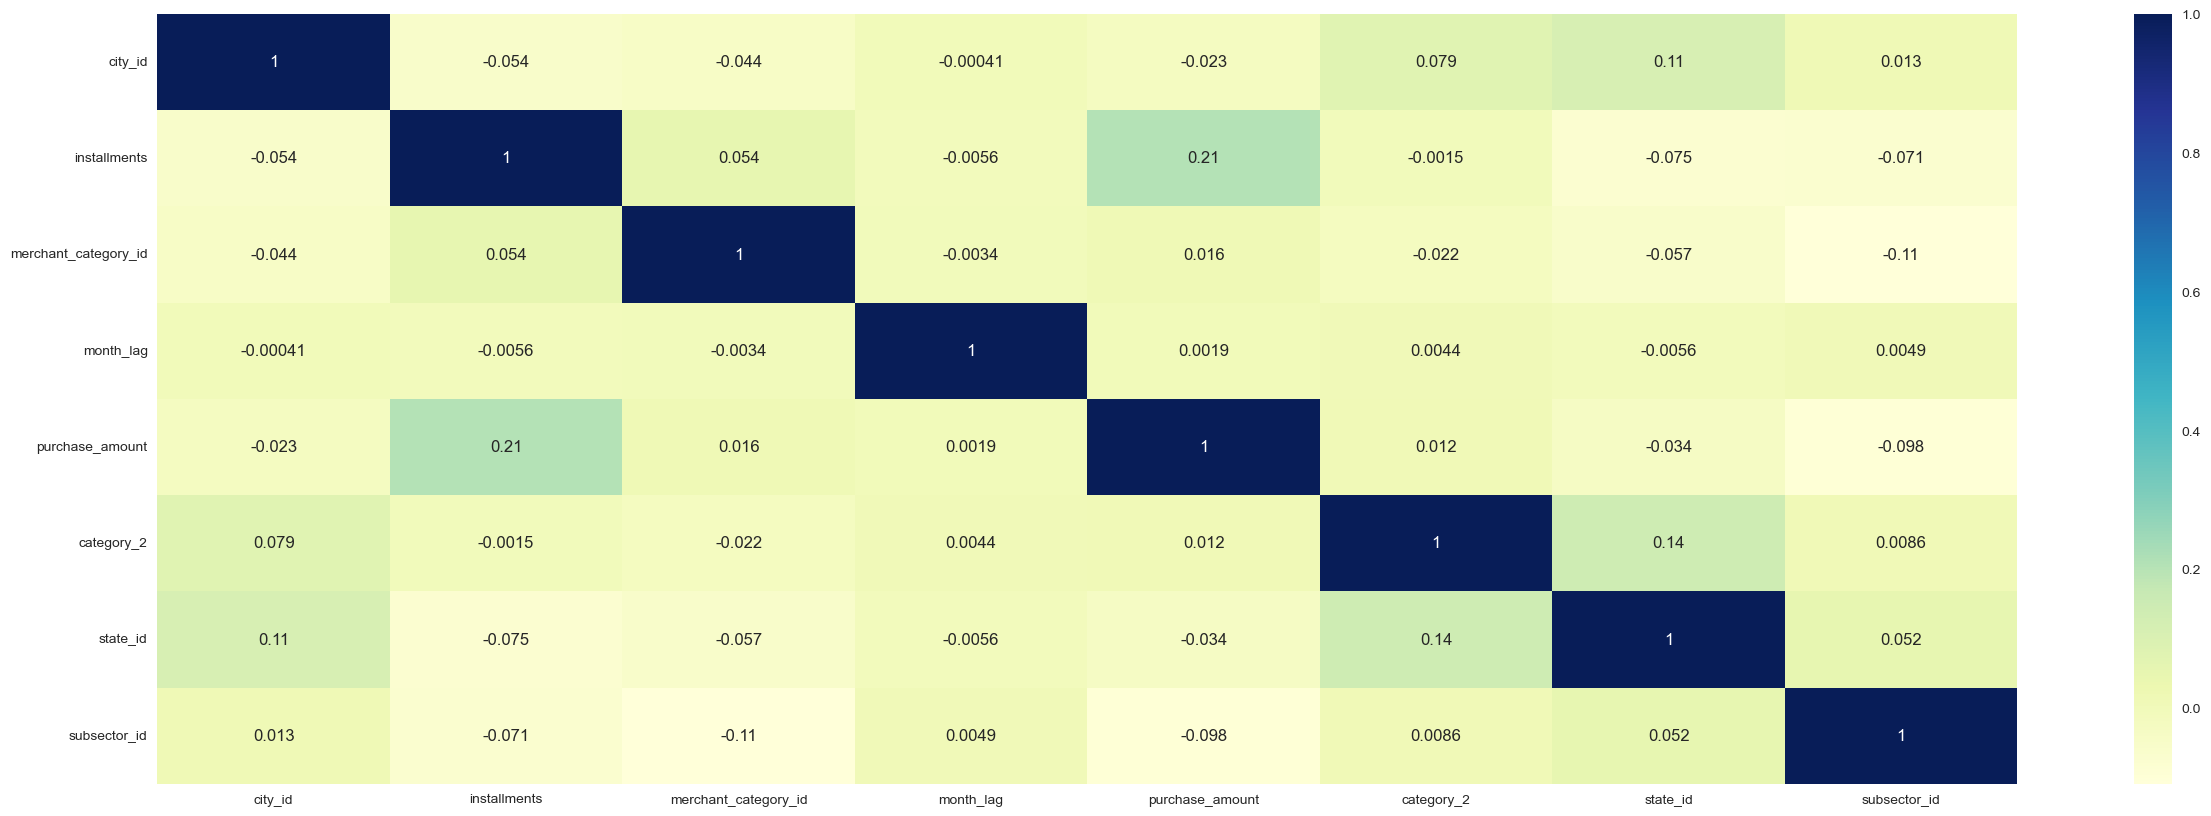

In [15]:
plt.figure(figsize = (30,10))
sns.heatmap(df_new_merchant_trans.corr(), annot = True, cmap="YlGnBu")
plt.show()

<Figure size 3000x1000 with 0 Axes>

<AxesSubplot:>

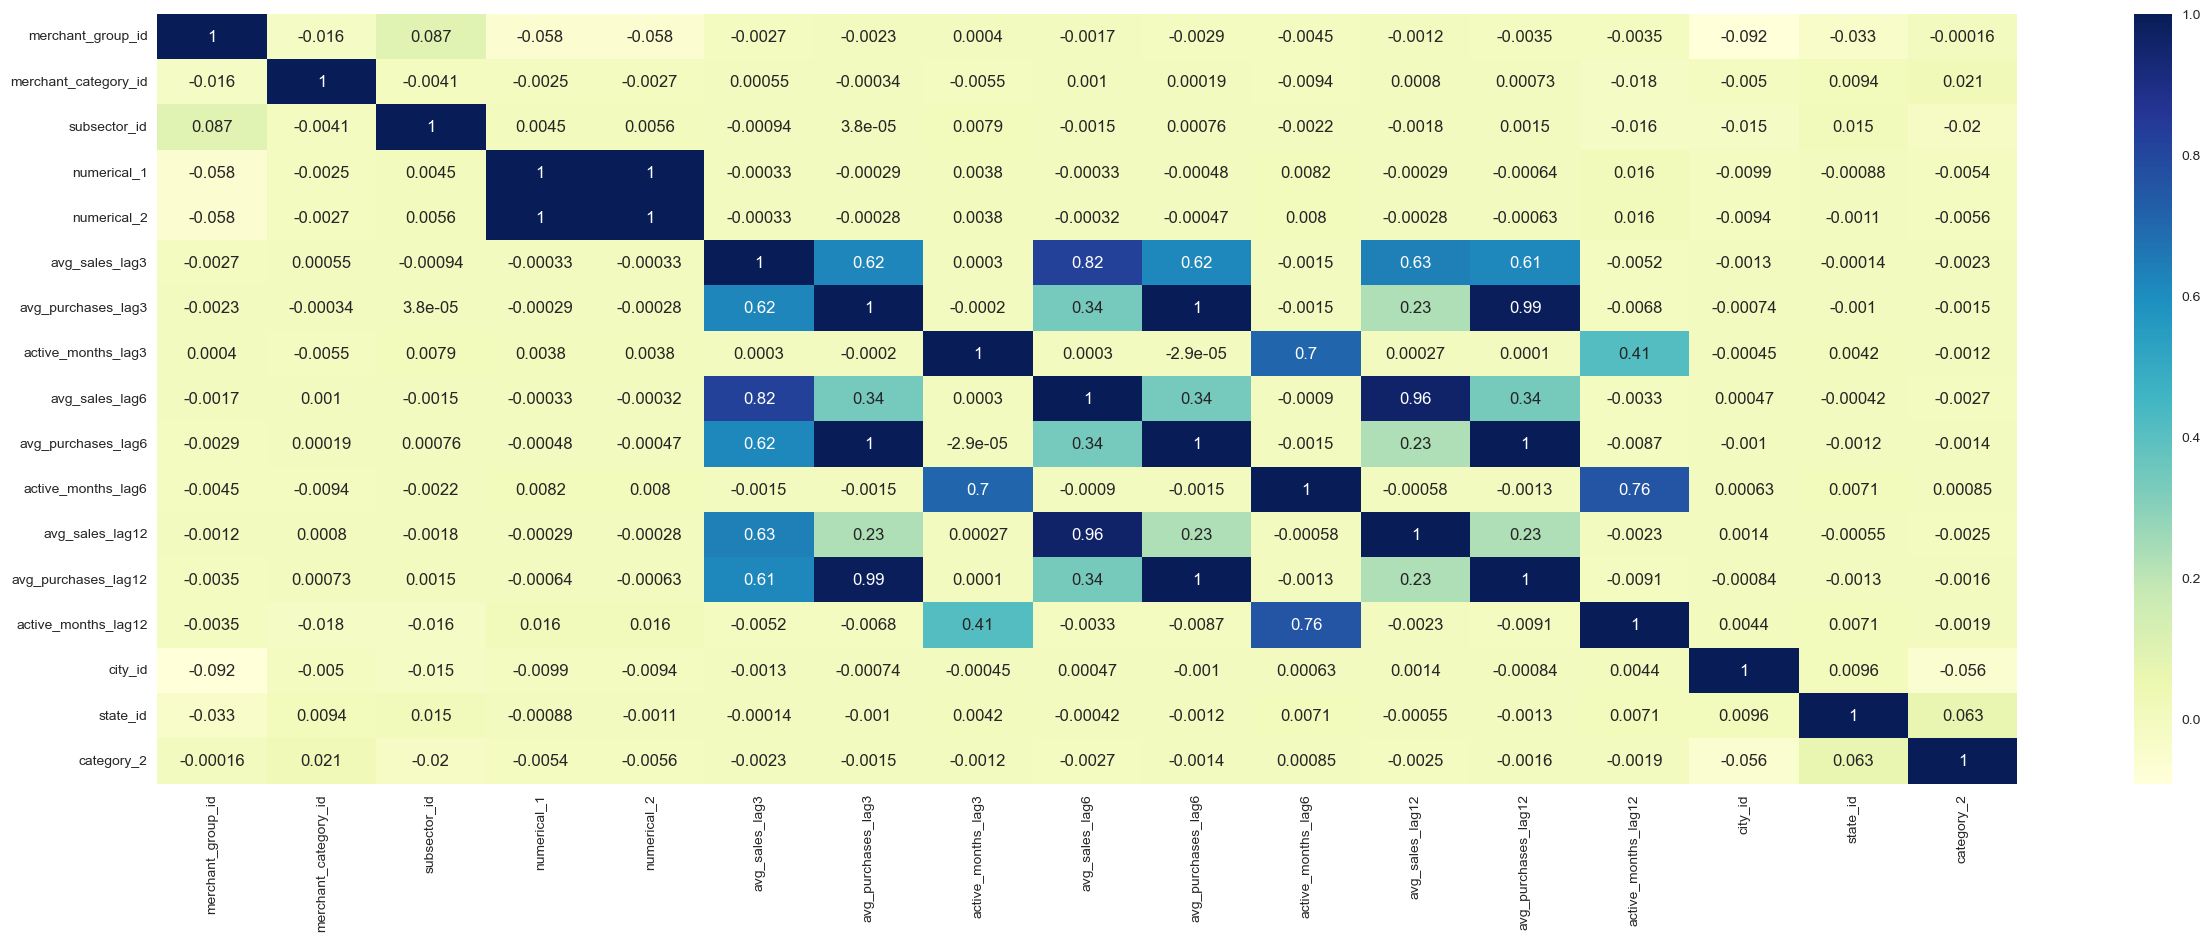

In [14]:
plt.figure(figsize = (30,10))
sns.heatmap(df_merchant.corr(), annot = True, cmap="YlGnBu")
plt.show()

<Figure size 3000x1000 with 0 Axes>

<AxesSubplot:>

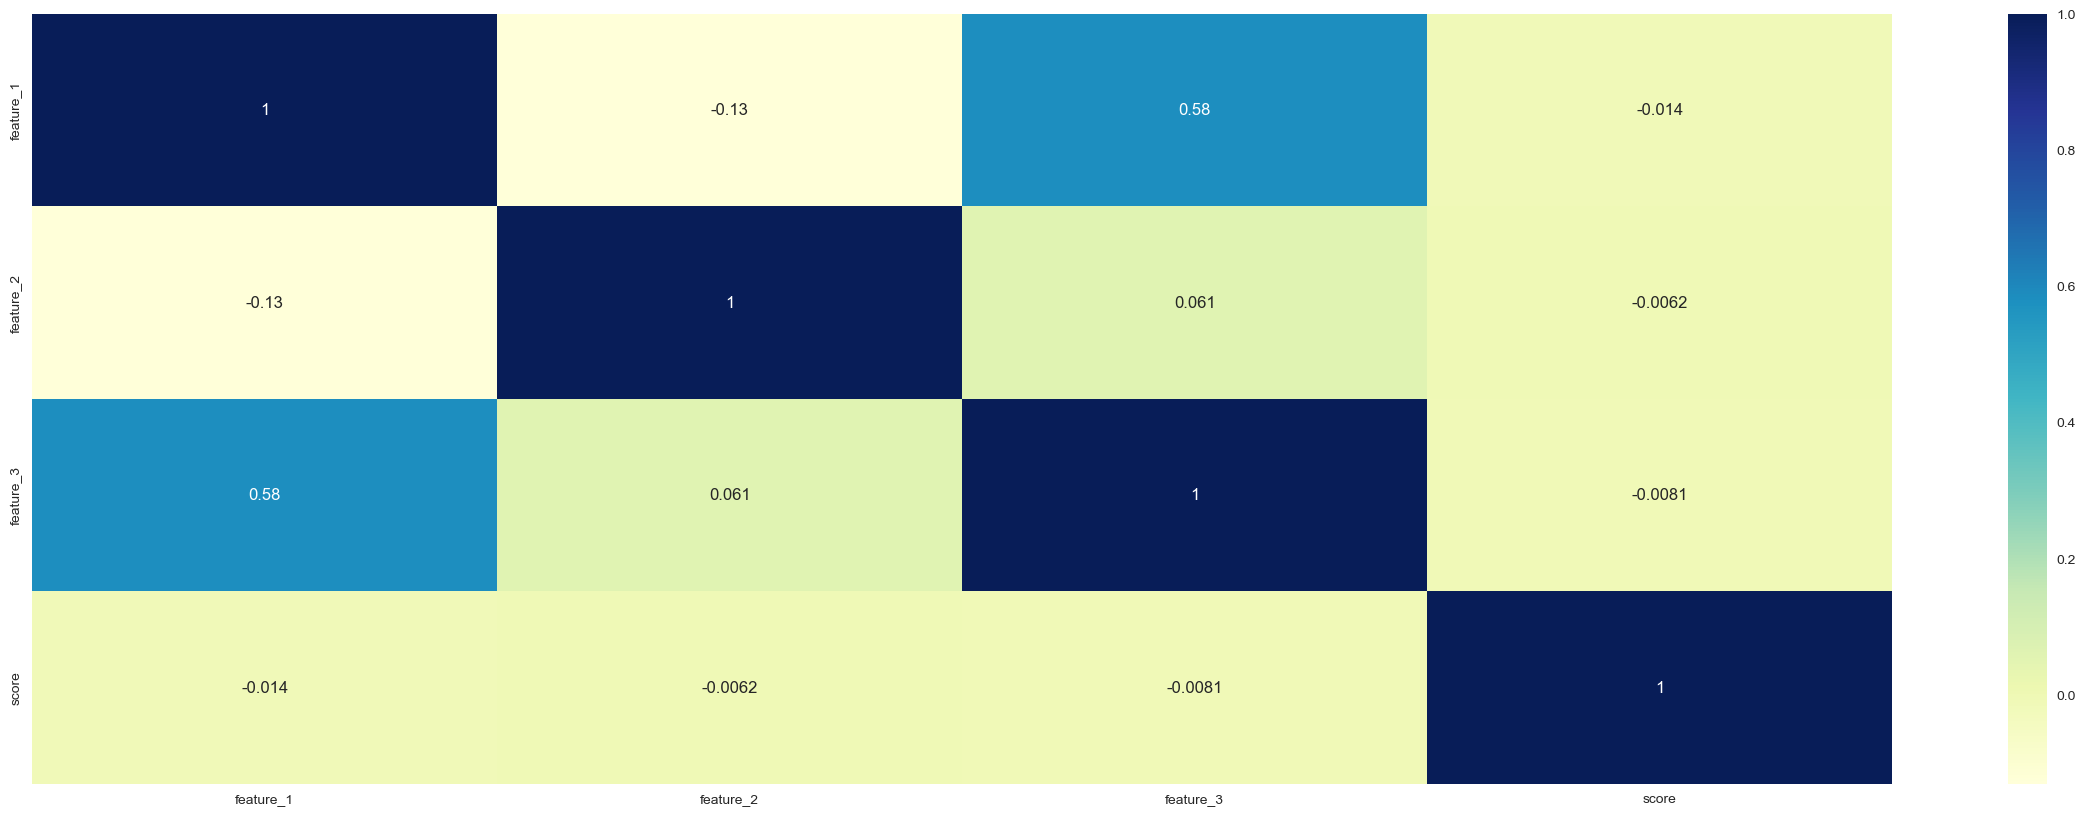

In [13]:
plt.figure(figsize = (30,10))
sns.heatmap(df_userscore.corr(), annot = True, cmap="YlGnBu")
plt.show()

<Figure size 3000x1000 with 0 Axes>

<AxesSubplot:>

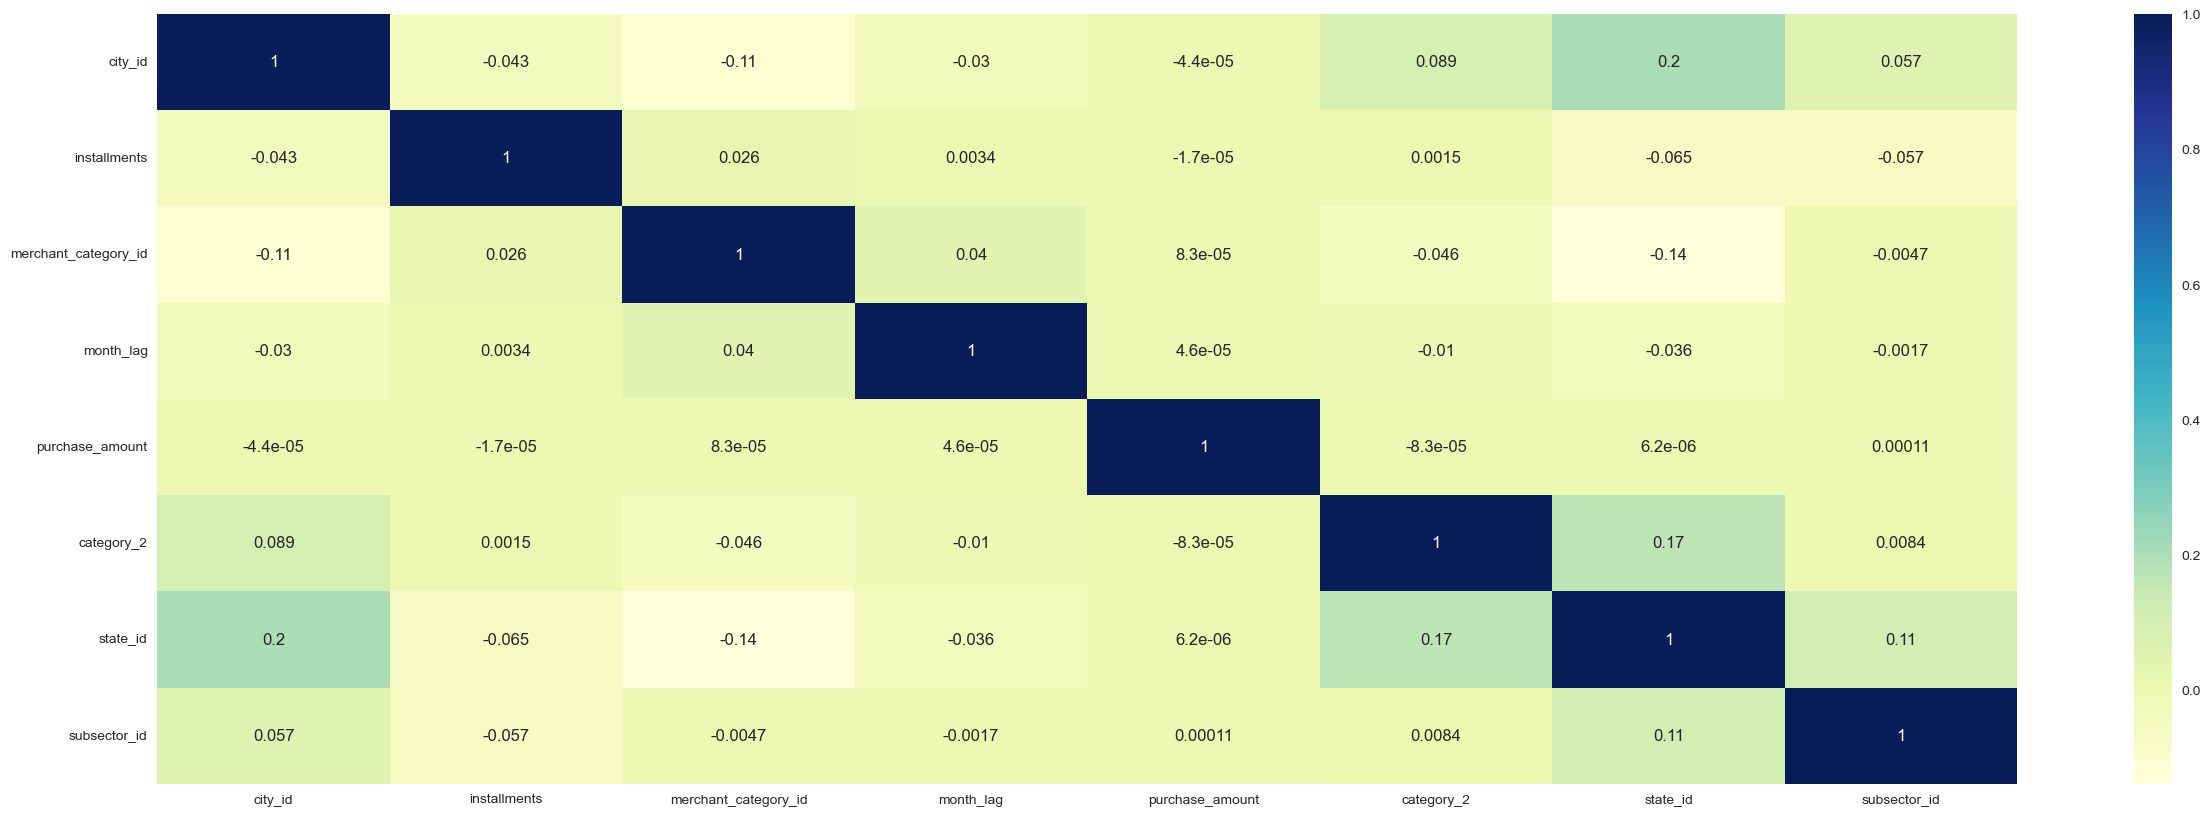

In [12]:
plt.figure(figsize = (30,10))
sns.heatmap(df_hist_trans.corr(), annot = True, cmap="YlGnBu")
plt.show()

> **From the corrolation matrix we find the same result as VIF test so we will drop some columns that will not give us meaningfull value**

In [5]:
df_merchant.describe()  #avg_purchases_lag3 ,avg_purchases_lag6,avg_purchases_lag12

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000,334696.000,334696.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334696.000,334696.000,322809.000
mean,31028.736,423.132,25.116,0.011,0.008,13.833,inf,2.994,21.651,inf,5.947,25.228,inf,11.599,102.918,11.861,2.380
std,31623.043,252.898,9.807,1.098,1.070,2395.490,NaN,0.095,3947.108,NaN,0.395,5251.842,NaN,1.520,107.091,6.177,1.563
min,1.000,-1.000,-1.000,-0.057,-0.057,-82.130,0.333,1.000,-82.130,0.167,1.000,-82.130,0.098,1.000,-1.000,-1.000,1.000
25%,3612.000,222.000,19.000,-0.057,-0.057,0.880,0.924,3.000,0.850,0.902,6.000,0.850,0.898,12.000,-1.000,9.000,1.000
50%,19900.000,373.000,27.000,-0.057,-0.057,1.000,1.017,3.000,1.010,1.027,6.000,1.020,1.043,12.000,69.000,9.000,2.000
75%,51707.250,683.000,33.000,-0.048,-0.048,1.160,1.147,3.000,1.230,1.216,6.000,1.290,1.266,12.000,182.000,16.000,4.000
max,112586.000,891.000,41.000,183.735,182.079,851844.640,inf,3.000,1513959.000,inf,6.000,2567408.000,inf,12.000,347.000,24.000,5.000


## Clean Data

### Deal with Inf Data

In [4]:
df_merchant = df_merchant.replace([np.inf, -np.inf], np.nan)

### Deal with Outliers 

> **These is our first trile with outliers when we use it it did not handle the outliers perfectly so we will try another way**

In [ ]:
def iqr(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    S = 1.5*IQR
    x[x < Q1 - S] = Q1 - S
    x[x > Q3 + S] = Q3 + S
    return x


In [ ]:
num_cols = df_hist_trans.select_dtypes('number').columns.tolist()
df_hist_trans[num_cols] = df_hist_trans[num_cols].apply(iqr)

In [ ]:
num_cols = df_new_merchant_trans.select_dtypes('number').columns.tolist()
df_new_merchant_trans[num_cols] = df_new_merchant_trans[num_cols].apply(iqr)

In [ ]:
num_cols = df_merchant.select_dtypes('number').columns.tolist()
df_merchant[num_cols] = df_merchant[num_cols].apply(iqr)

### Deal with Null values

|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|0.48%| |MCAR|Object|Drop Null Values |
|category_3|0.61%| |MCAR|Object|Most Frequent |
|category_2|9.11%||MCAR|Object|Most Frequent |

In [12]:
df_new_merchant_trans['merchant_id'] = df_new_merchant_trans['merchant_id'].dropna()

mar_cols = ['category_3', 'category_2']

imputer = SimpleImputer(strategy='most_frequent')
df_new_merchant_trans[mar_cols] = imputer.fit_transform(df_new_merchant_trans[mar_cols])


|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|merchant_id|1.34%| |MCAR|Object|Drop Null Values |
|category_3|2.85%| |MCAR|Object|Most Frequent |
|category_2|5.69%||MCAR|Object|Most Frequent |

In [13]:
df_hist_trans['merchant_id'] = df_hist_trans['merchant_id'].dropna()



mar_cols = [ 'category_3', 'category_2']

imputer = SimpleImputer(strategy='most_frequent')
df_hist_trans[mar_cols] = imputer.fit_transform(df_hist_trans[mar_cols])


|Column|Null percentage|Missing value patterns|Missing value mechanism|Data Type|Solution|
| --- | --- | --- |--- |--- |---|
|avg_sales_lag12 |0.00%| |MCAR|Object|Mean |
|avg_sales_lag6 |0.00%| |MCAR|Object|Mean|
|avg_sales_lag3 |0.00%| |MCAR|Object|Mean|
|category_2|0.61%||MCAR|Object|Most Frequent |

In [14]:

mar_cols = ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']

imputer = SimpleImputer(strategy='mean')
df_merchant[mar_cols] = imputer.fit_transform(df_merchant[mar_cols])




mar_cols = ['category_2']

imputer = SimpleImputer(strategy='most_frequent')
df_merchant[mar_cols] = imputer.fit_transform(df_merchant[mar_cols])

C:\Users\Lap-5\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


### Change Data types

In [15]:
df_userscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   card_id             201917 non-null  object 
 1   first_active_month  201917 non-null  object 
 2   feature_1           201917 non-null  int8   
 3   feature_2           201917 non-null  int8   
 4   feature_3           201917 non-null  int8   
 5   score               201917 non-null  float64
dtypes: float64(1), int8(3), object(2)
memory usage: 5.2+ MB


In [16]:
df_new_merchant_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int16  
 3   category_1            object 
 4   installments          int16  
 5   category_3            object 
 6   merchant_category_id  int16  
 7   merchant_id           object 
 8   month_lag             int8   
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            object 
 12  state_id              int8   
 13  subsector_id          int8   
dtypes: float64(1), int16(3), int8(3), object(7)
memory usage: 136.7+ MB


In [17]:
df_hist_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int16  
 3   category_1            object 
 4   installments          int16  
 5   category_3            object 
 6   merchant_category_id  int16  
 7   merchant_id           object 
 8   month_lag             int8   
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            object 
 12  state_id              int8   
 13  subsector_id          int8   
dtypes: float64(1), int16(3), int8(3), object(7)
memory usage: 2.0+ GB


In [18]:
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int32  
 2   merchant_category_id         334696 non-null  int16  
 3   subsector_id                 334696 non-null  int8   
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334696 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int8   
 12  avg_sales_lag6               334696 non-null  float64
 13 

In [19]:
df_hist_trans[['state_id','city_id','merchant_category_id','subsector_id']] = df_hist_trans[['state_id','city_id','merchant_category_id','subsector_id']].astype('object')
df_new_merchant_trans[['state_id','city_id','merchant_category_id','subsector_id']] = df_new_merchant_trans[['state_id','city_id','merchant_category_id','subsector_id']].astype('object')
df_merchant[['state_id','city_id','merchant_group_id','merchant_category_id','subsector_id','category_2','category_1']] = df_merchant[['state_id','city_id','merchant_group_id','merchant_category_id','subsector_id','category_2','category_1']].astype('object')


In [20]:
# Convert "first_active_month" column to datetime format
df_userscore['first_active_month'] = pd.to_datetime(df_userscore['first_active_month'], format='%b-%y')
df_userscore['first_active_month'].unique

<bound method Series.unique of 0        2017-06-01
1        2017-01-01
2        2016-08-01
3        2017-09-01
4        2017-11-01
            ...    
201912   2017-09-01
201913   2015-10-01
201914   2017-08-01
201915   2016-07-01
201916   2017-07-01
Name: first_active_month, Length: 201917, dtype: datetime64[ns]>

In [21]:
df_new_merchant_trans['purchase_date'] = pd.to_datetime(df_new_merchant_trans['purchase_date'], format='%Y-%m-%d %H:%M:%S')
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'], format='%Y-%m-%d %H:%M:%S')

### Drop Columns with high VIF values 

From above we will need to drope data that have high VIF value, We will take threshold higher than 10 : 
* numerical_1 
* avg_sales_lag3 
* avg_purchases_lag3 
* active_months_lag3 

In [22]:
df_merchant = df_merchant.drop('numerical_1', axis=1)
df_merchant = df_merchant.drop('avg_sales_lag6', axis=1)
df_merchant = df_merchant.drop('avg_purchases_lag6', axis=1)
df_merchant = df_merchant.drop('active_months_lag6', axis=1)
df_merchant = df_merchant.drop('avg_sales_lag12', axis=1)
df_merchant = df_merchant.drop('avg_purchases_lag12', axis=1)


### Solve Outliers

> **These is the second method to deal with outliers and we think it is more suitable with our data** 

In [23]:
df_hist_trans['installments']=df_hist_trans['installments'].replace(999, 11)


In [24]:
df_new_merchant_trans['installments']=df_new_merchant_trans['installments'].replace(999, 11)
df_new_merchant_trans['state_id']=df_new_merchant_trans['state_id'].replace(-1, 0)

In [25]:
def iqr(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    S = 1.5*IQR
    x[x < Q1 - S] = Q1 - S
    x[x > Q3 + S] = Q3 + S
    return x


In [26]:
cols = ['active_months_lag3','avg_purchases_lag3','avg_sales_lag3','numerical_2']
df_merchant[cols] = df_merchant[cols].apply(iqr)

### Question 3

> **Q3.** Perform necessary data cleaning based on your answer to Q2.

> **We used group of methodes to clean our data as we try to clean each table first befor compining the data , So for each problem we used  various techniqes**

**1. Deal with Inf Data**</br>
We find INF data only on merchant table. To solve it we convert it into nan value to deal with it as Null values.
**2. Deal with Null values**</br>
We deal with Null values in three different ways: 
> **A**. Drop Null values  for merchant_id columns

> **B**. Impute Null values using  SimpleImputer ,and the strategy is most_frequent for categorical data

> **C**. Impute Null values using  SimpleImputer ,and the strategy is mean for numerical data

**3. Change Data types** </br>
We Change the data type of some columns, because some columns were numeical but we need them to be categorical, and some columns were numerical we need them to be datetime.</br>  
**4. Drop Columns with high corrolation**</br>
Some columns have high relation between each other so we need to drop some of them.</br></br> 
**5. Solve Outliers**</br>
To solve outliers we deal with each columns alone as some of columns need to replace outliers with specific value and some of them we only deal with them using IQR method. 

## Save Data 

> **Save the data after cleaning**

In [27]:
df_new_merchant_trans.to_csv('df_new_merchant_trans.csv')
df_hist_trans.to_csv('df_hist_trans.csv')
df_merchant.to_csv('df_merchant.csv')
df_userscore.to_csv('df_userscore.csv')

## Exploratory Data Analysis (EDA)

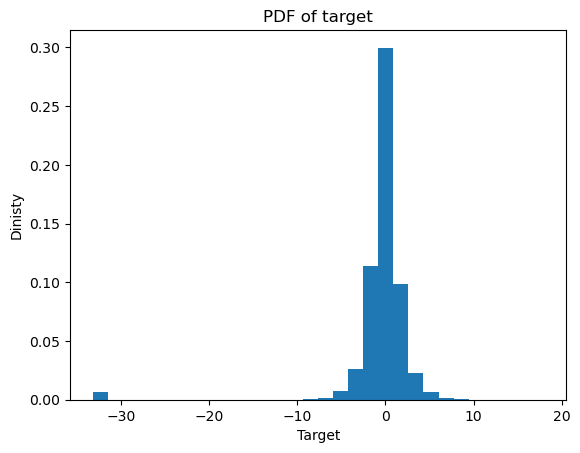

In [21]:
# generate a histogram of the 'age' column
fig = plt.hist(df_userscore['score'],density=True, bins=30)
x = plt.xlabel('Target')
x = plt.ylabel('Dinisty')
x = plt.title('PDF of target')
plt.show()

> **From above we can say that the distrbution of the target column without the outliers is normal**

> **first_active_month Vs. score**

In [13]:
# Convert "first_active_month" column to datetime format
df['first_active_month'] = pd.to_datetime(df['first_active_month'], format='%b-%y')
df['first_active_month'].unique

<bound method Series.unique of 0          2016-08-01
1          2016-08-01
2          2016-08-01
3          2016-08-01
4          2016-08-01
              ...    
20025728   2018-01-01
20025729   2018-01-01
20025730   2018-01-01
20025731   2016-05-01
20025732   2016-05-01
Name: first_active_month, Length: 20025733, dtype: datetime64[ns]>

<Figure size 2000x1000 with 0 Axes>

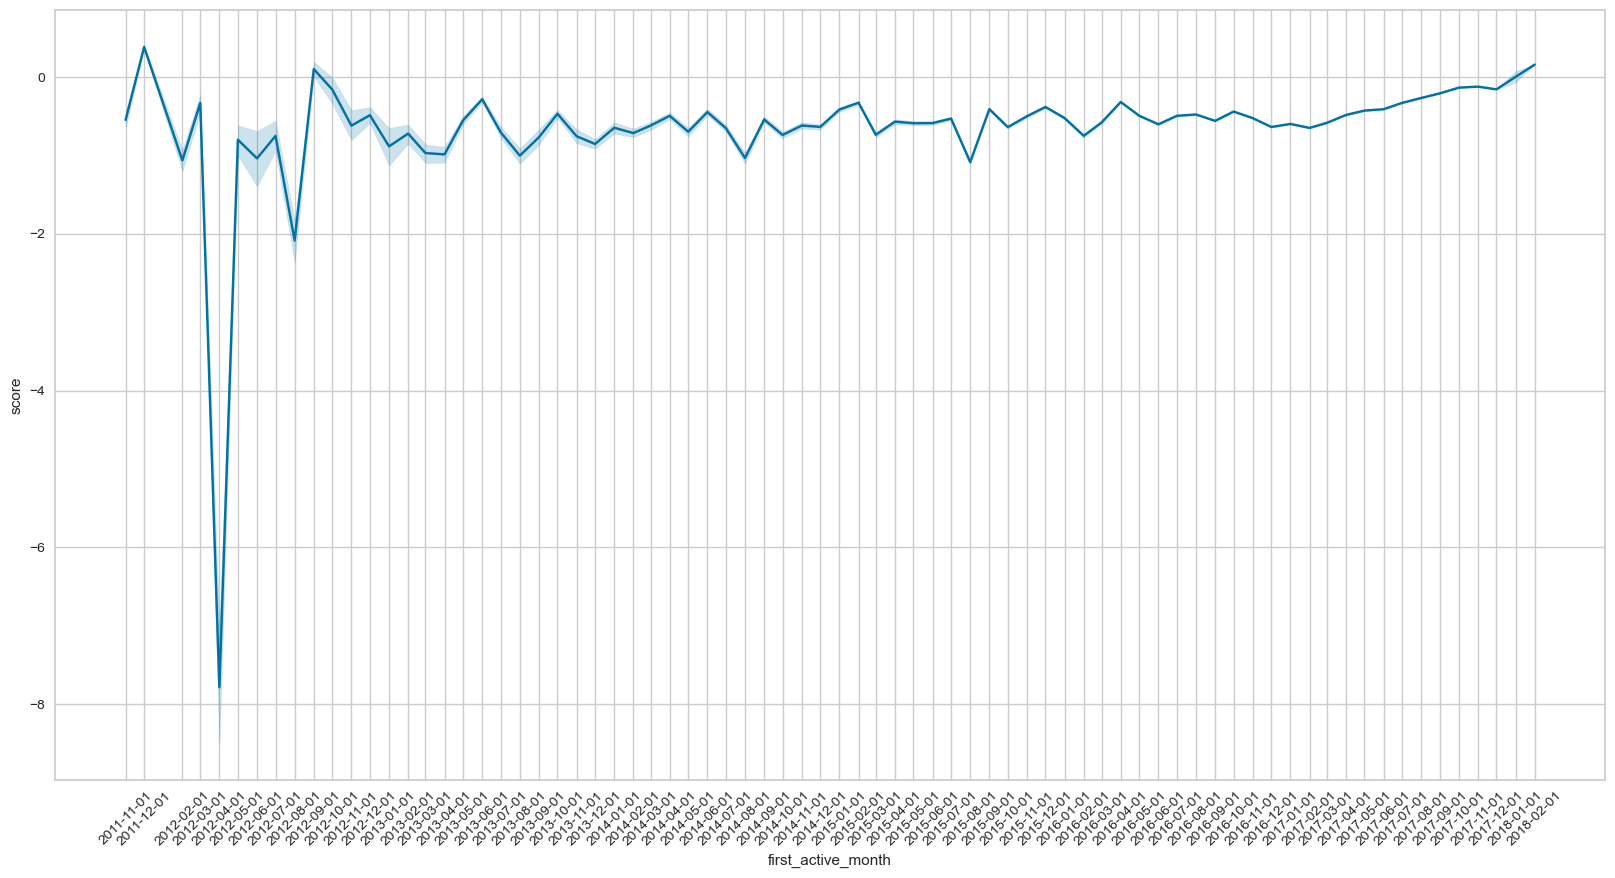

In [40]:
plt.figure(figsize=(20,10))
fig = sns.lineplot(data=df, x="first_active_month", y='score')
x = plt.xticks(list(set(df.first_active_month)), rotation=45)
plt.show()

> **Here we will view the relation between number of active days & loyalty score**

In [15]:
# Convert "first_active_month" column to datetime format
df_userscore['first_active_month'] = pd.to_datetime(df_userscore['first_active_month'], format='%b-%y')
df_userscore['first_active_month'].unique

<bound method Series.unique of 0        2017-06-01
1        2017-01-01
2        2016-08-01
3        2017-09-01
4        2017-11-01
            ...    
201912   2017-09-01
201913   2015-10-01
201914   2017-08-01
201915   2016-07-01
201916   2017-07-01
Name: first_active_month, Length: 201917, dtype: datetime64[ns]>

In [16]:
df_userscore['first_active_month'] = pd.to_datetime(df_userscore['first_active_month'], format='%Y-%M')
today = pd.to_datetime('today')
df_userscore['first_active_month_diff_from_today'] = (12 * (today.year - df_userscore['first_active_month'].dt.year) + (today.month - df_userscore['first_active_month'].dt.month)) 


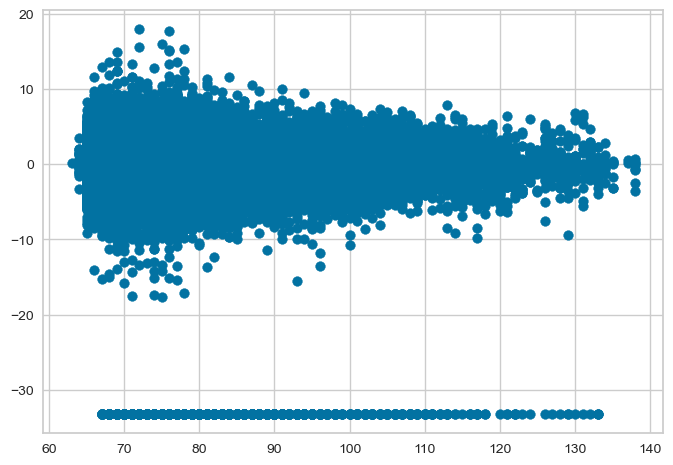

In [17]:
plt.scatter(df_userscore['first_active_month_diff_from_today'], df_userscore['score'])

# Add labels and title
# plt.title("Intersection of Column1 and Column2")
# plt.xlabel("Column1")
# plt.ylabel("Column2")

# Display plot
plt.show()

> **Descover the category columns in both transaction table and merchant table** 

<Figure size 600x400 with 0 Axes>

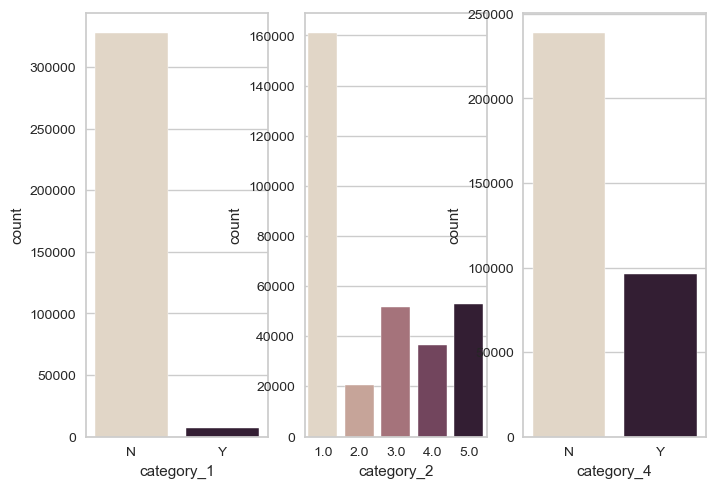

In [66]:
fig = plt.figure(figsize=(6, 4), dpi=100)
fig, axes = plt.subplots(1,3)
x=sns.countplot(data=df_merchant, x="category_1" , palette="ch:.25", ax=axes[0])
x=sns.countplot(data=df_merchant, x="category_2" , palette="ch:.25", ax=axes[1])
x=sns.countplot(data=df_merchant, x="category_4" , palette="ch:.25", ax=axes[2])
# Show the figure
plt.show()

<Figure size 600x400 with 0 Axes>

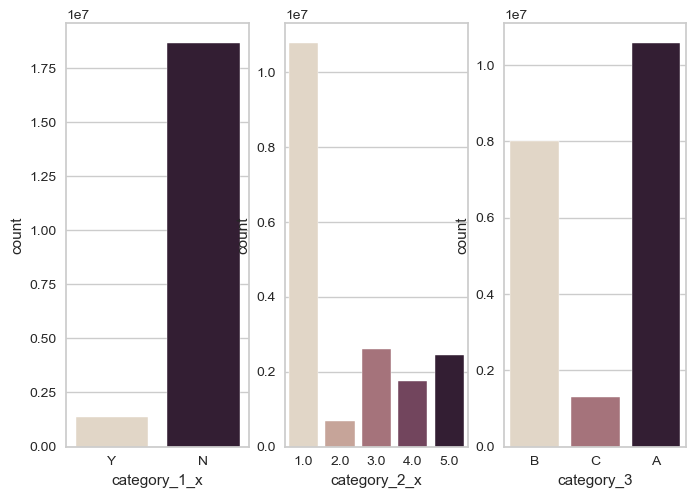

In [67]:
fig = plt.figure(figsize=(6, 4), dpi=100)
fig, axes = plt.subplots(1,3)
x=sns.countplot(data=df, x="category_1_x" , palette="ch:.25", ax=axes[0])
x=sns.countplot(data=df, x="category_2_x" , palette="ch:.25", ax=axes[1])
x=sns.countplot(data=df, x="category_3" , palette="ch:.25", ax=axes[2])
# Show the figure
plt.show()

> **We can say that the distribution of catergories in both new data & transaction data is the same** 

<BarContainer object of 7 artists>

Text(0.5, 0, 'Day of the week')

Text(0, 0.5, 'Number of purchases')

Text(0.5, 1.0, 'Number of purchases by day of the week')

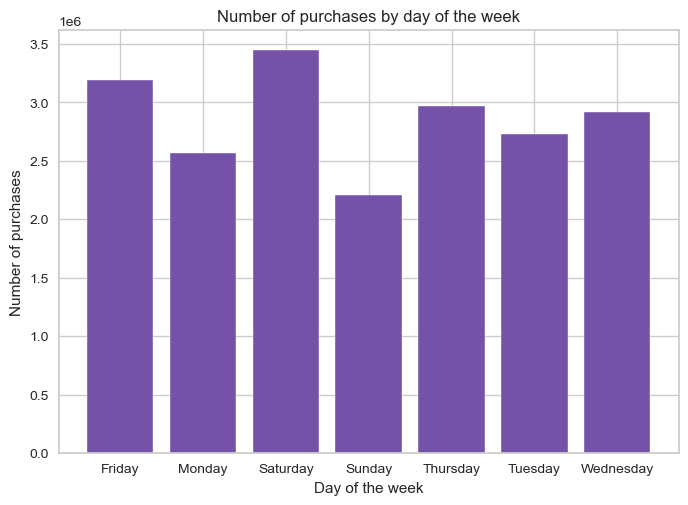

In [41]:
# Extract the day of the week from the datetime object
df['day_of_week'] = df['purchase_date'].dt.day_name()

# Group the data by day of the week and count the number of purchases
purchases_by_day = df.groupby('day_of_week')['purchase_amount'].count()

# Create a bar plot of the number of purchases by day of the week
plt.bar(purchases_by_day.index, purchases_by_day.values,color = '#7452A8')
plt.xlabel('Day of the week')
plt.ylabel('Number of purchases')
plt.title('Number of purchases by day of the week')
plt.show()

> **The peack of Purchase amount is in Friday & saturday**

<BarContainer object of 24 artists>

Text(0.5, 0, 'Hours of the day')

Text(0, 0.5, 'Number of purchases')

Text(0.5, 1.0, 'Number of purchases by hour')

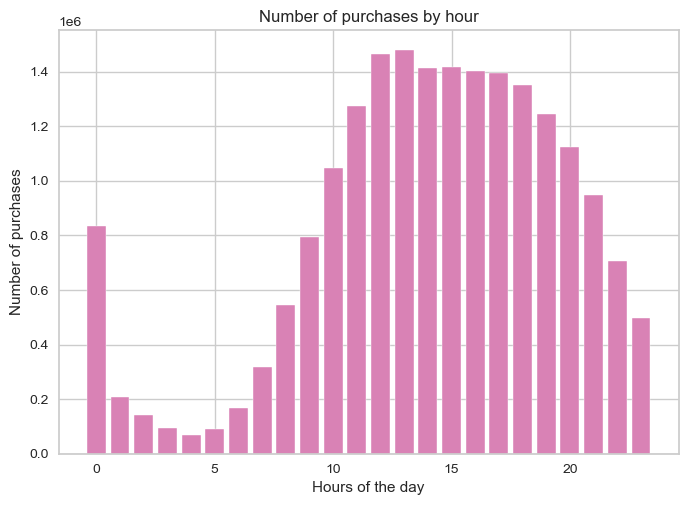

In [39]:
# Convert the date column to a datetime object
# df['date'] = pd.to_datetime(df['date'])

# Extract the hour from the datetime object
df['hour'] = df['purchase_date'].dt.hour

# Group the data by hour and count the number of purchases
purchases_by_hour = df.groupby('hour')['purchase_date'].count()

# Plot the number of purchases against the hours of the day
plt.bar(purchases_by_hour.index, purchases_by_hour.values,color = '#D982B5')
plt.xlabel('Hours of the day')
plt.ylabel('Number of purchases')
plt.title('Number of purchases by hour')
plt.show()

<BarContainer object of 12 artists>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Purchase amount')

Text(0.5, 1.0, 'Purchases by month for 2017')

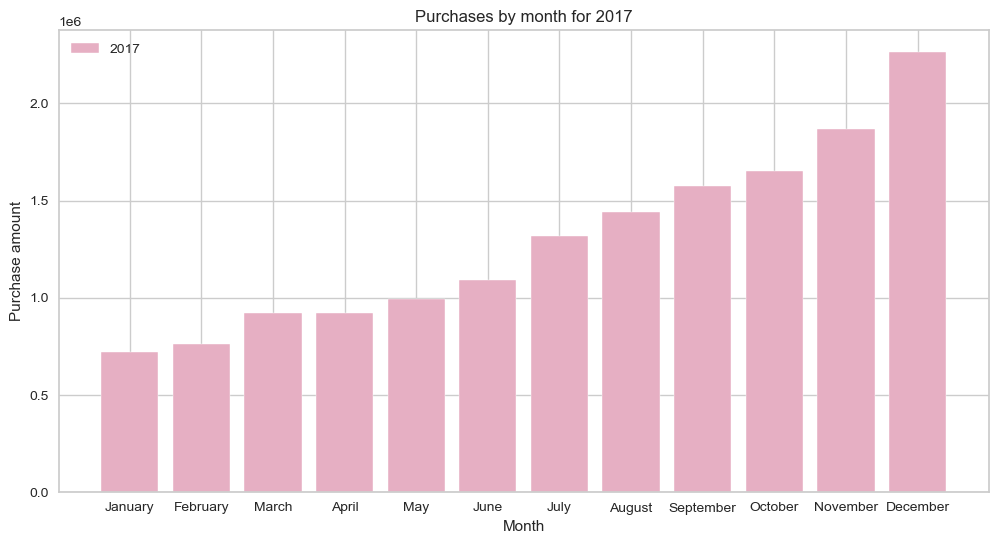

<BarContainer object of 4 artists>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Purchase amount')

Text(0.5, 1.0, 'Purchases by month for 2018')

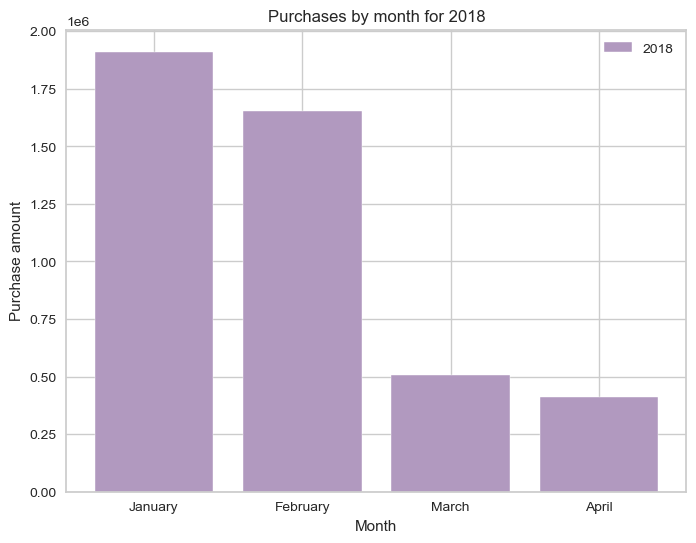

In [67]:
import calendar
# Convert the month numbers to month names
month_names = [calendar.month_name[i] for i in range(1, 13)]
fig = plt.figure(figsize=(12, 6), dpi=100)


# Create a line plot of the purchases by month for 2017 with month names
plt.bar(month_names, purchases_by_month_2017.values, label='2017',color ='#E6AFC3')
plt.xlabel('Month')
plt.ylabel('Purchase amount')
plt.title('Purchases by month for 2017')
plt.legend()
plt.show()


month_names = [calendar.month_name[i] for i in range(1, 5)]
fig = plt.figure(figsize=(8, 6), dpi=100)

plt.bar(month_names, purchases_by_month_2018.values, label='2018',color ='#B199BF')
plt.xlabel('Month')
plt.ylabel('Purchase amount')
plt.title('Purchases by month for 2018')
plt.legend()
plt.show()

> **The above two graphs tell us that the Purchase amount was increasing until march in 2018**

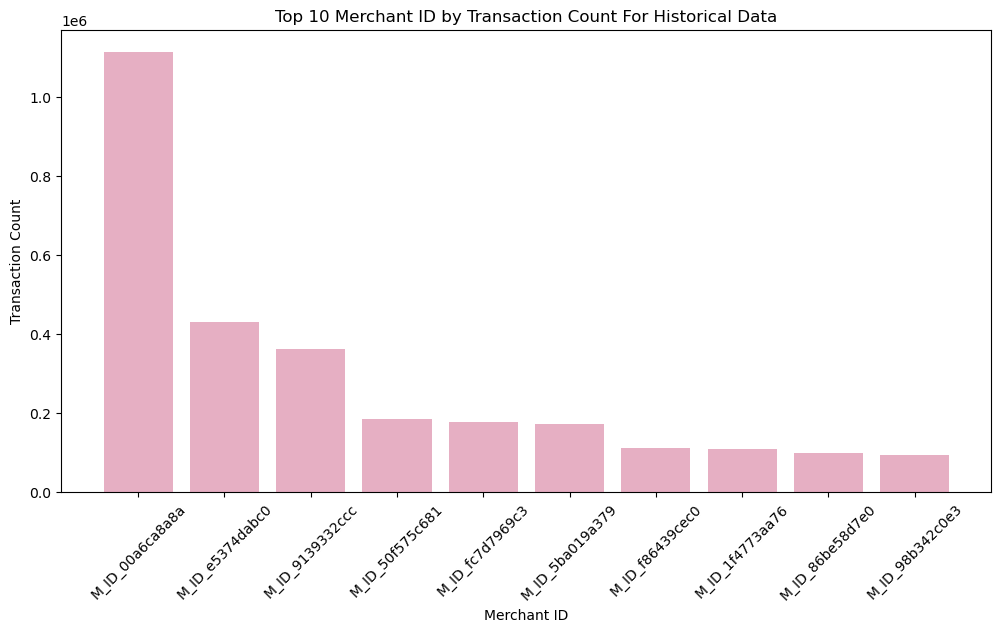

In [12]:

# Group transactions by merchant id and count the number of transactions in each category
merchant_counts = df_hist_trans.groupby('merchant_id').size().reset_index(name='count')

# Sort the merchant categories by transaction count in descending order
merchant_counts = merchant_counts.sort_values(by='count', ascending=False)

# Plot a bar chart of the top 10 merchant categories by transaction count
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.bar(merchant_counts['merchant_id'][:10], merchant_counts['count'][:10],color ='#E6AFC3')
x = plt.xticks( rotation=45)
plt.xlabel('Merchant ID')
plt.ylabel('Transaction Count')
plt.title('Top 10 Merchant ID by Transaction Count For Historical Data')
plt.show()

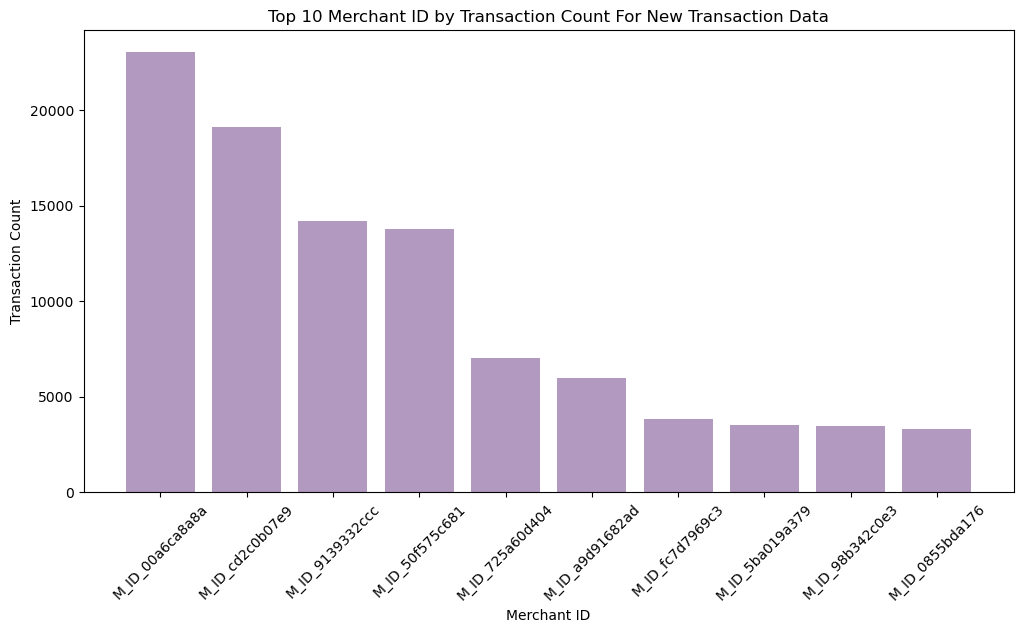

In [13]:

# Group transactions by merchant id and count the number of transactions in each category
merchant_counts = df_new_merchant_trans.groupby('merchant_id').size().reset_index(name='count')

# Sort the merchant categories by transaction count in descending order
merchant_counts = merchant_counts.sort_values(by='count', ascending=False)

# Plot a bar chart of the top 10 merchant categories by transaction count
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.bar(merchant_counts['merchant_id'][:10], merchant_counts['count'][:10],color ='#B199BF')
x = plt.xticks( rotation=45)
plt.xlabel('Merchant ID')
plt.ylabel('Transaction Count')
plt.title('Top 10 Merchant ID by Transaction Count For New Transaction Data')
plt.show()

> **From above we can notice that there some merchents were in the top 10 but now they are not** 

In [4]:
df_hist_trans.info()
df_new_merchant_trans.info()
df_merchant.info()
df_userscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_

In [25]:
list(location_counts['city_id'].astype('object')[:10])

[69, -1, 19, 158, 17, 331, 143, 88, 137, 333]

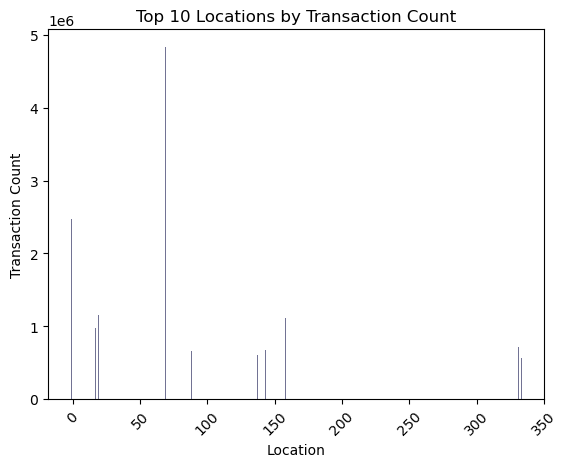

In [28]:

# Group transactions by location and count the number of transactions in each location
location_counts = df_hist_trans.groupby('city_id').size().reset_index(name='count')

# Sort the locations by transaction count in descending order
location_counts = location_counts.sort_values(by='count', ascending=False)

# Plot a bar chart of the top 10 locations by transaction count
plt.bar(location_counts['city_id'].astype('object')[:10], location_counts['count'][:10],color ='#727394')
x = plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Transaction Count')
plt.title('Top 10 Locations by Transaction Count')
plt.show()

### Question 5

> **Q5.** Propose two hypothesis tests exploring information related to user loyalty score. For each hypothesis test, you must describe the motivation (why this hypothesis is interesting and important to test), null hypothesis, and select a proper statistical test to report the test result.

In [31]:

result = pd.concat([df_new_merchant_trans, df_hist_trans])
## Here we will join (inner join) between all transaction data and user score data 
df = pd.merge(result, df_userscore, on='card_id')
# ## Here we will join (left join) between all transaction data and merchant data 
# df = pd.merge(result2, df_merchant, on='merchant_id')


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19249694 entries, 0 to 19249693
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int16  
 3   category_1            object 
 4   installments          int16  
 5   category_3            object 
 6   merchant_category_id  int16  
 7   merchant_id           object 
 8   month_lag             int8   
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int8   
 13  subsector_id          int8   
 14  first_active_month    object 
 15  feature_1             int8   
 16  feature_2             int8   
 17  feature_3             int8   
 18  score                 float64
dtypes: float64(3), int16(3), int8(6), object(7)
memory usage: 1.8+ GB


> **Is there a significant difference in the average customer loyalty score between customers who made purchases in the morning (6am - 12pm) and customers who made purchases in the evening (6pm - 12am)?**

In [34]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format='%Y-%m-%d %H:%M:%S')

In [35]:
df['purchase_hour'] = df['purchase_date'].dt.hour

In [36]:
import pandas as pd
from scipy.stats import ttest_ind


# split the data into morning and evening purchases
morning = df.loc[(df['purchase_hour'] >= 6) & (df['purchase_hour'] < 12), 'score']
evening = df.loc[(df['purchase_hour'] >= 18) | (df['purchase_hour'] < 0), 'score']

# perform a two-sample t-test
t_stat, p_val = ttest_ind(morning, evening, equal_var=False)

# print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

t-statistic:  1.8281639988094747
p-value:  0.06752497637086355


> **Observation**

The results of the hypothesis test suggest that there may be a difference in the average customer loyalty score between customers who made purchases in the morning and those who made purchases in the evening. However, we cannot be completely certain that this difference is real and not just due to chance.

The t-value of 1.83 indicates that the difference in customer loyalty score between the two groups is not likely to be a random occurrence, but the p-value of 0.068 suggests that this difference may still occur by chance in about 6.85% of cases.

Therefore, we cannot confidently conclude that the difference in customer loyalty score between morning and evening purchases is statistically significant. We would need more evidence to support this claim before making any definitive conclusions.

> **Is there a significant difference in the average customer loyalty score between customers who made purchases with a high installment percentage (greater than the median installment percentage) and customers who made purchases with a low installment percentage (less than or equal to the median installment percentage)?**

In [37]:
#First i will solve the outlier in the data 
df['installments']=df['installments'].replace(999, 11)


In [41]:
df['installments'].median()

0.0

In [38]:

# calculate the median installment percentage
median_installment_pct = df['installments'].median()

# split the data into high- and low-installment-percentage groups
high_installment_pct = df.loc[df['installments'] > median_installment_pct, 'score']
low_installment_pct = df.loc[df['installments'] <= median_installment_pct, 'score']

# perform a two-sample t-test
t_stat, p_val = ttest_ind(high_installment_pct, low_installment_pct, equal_var=False)

# print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

t-statistic:  -144.91499967020334
p-value:  0.0


>  **Observation**

The t-value of -144.91 indicates that the mean customer loyalty score for purchases made with low installment percentages is much higher than the mean customer loyalty score for purchases made with high installment percentages.

 The p-value of 0.0 suggests that this difference is extremely unlikely to occur by chance, and we can reject the null hypothesis that there is no difference in the average customer loyalty score between purchases made with high and low installment percentages.

**We can explain that by if the user hase zero installments it will take high score of loyalty**

In [58]:
df[df['installments'] <= median_installment_pct].score.mean()

-0.34235752485529214

In [59]:
df[df['installments'] > median_installment_pct].score.mean()

-0.5849838494756087

# Trial One

## Load Data 

In [27]:
df_userscore = reduce_memory_usage( pd.read_csv('df_userscore.csv'))
df_hist_trans = reduce_memory_usage(pd.read_csv('df_hist_trans.csv'))
df_new_merchant_trans = reduce_memory_usage(pd.read_csv('df_new_merchant_trans.csv'))
df_merchant = reduce_memory_usage(pd.read_csv('df_merchant.csv'))

Mem. usage decreased to  5.97 Mb (44.6% reduction)
Mem. usage decreased to 2110.04 Mb (36.7% reduction)
Mem. usage decreased to 142.28 Mb (36.7% reduction)
Mem. usage decreased to 28.09 Mb (35.3% reduction)


In [ ]:
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   334696 non-null  int32  
 1   merchant_id                  334696 non-null  object 
 2   merchant_group_id            334696 non-null  int32  
 3   merchant_category_id         334696 non-null  int16  
 4   subsector_id                 334696 non-null  int8   
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334696 non-null  float64
 10  avg_purchases_lag3           334693 non-null  float64
 11  active_months_lag3           334696 non-null  int8   
 12  active_months_lag12          334696 non-null  int8   
 13 

## Change Data Types

In [28]:
df_hist_trans[['state_id','city_id','merchant_category_id','subsector_id']] = df_hist_trans[['state_id','city_id','merchant_category_id','subsector_id']].astype('object')
df_new_merchant_trans[['state_id','city_id','merchant_category_id','subsector_id']] = df_new_merchant_trans[['state_id','city_id','merchant_category_id','subsector_id']].astype('object')
df_merchant[['state_id','city_id','merchant_group_id','merchant_category_id','subsector_id','category_2','category_1']] = df_merchant[['state_id','city_id','merchant_group_id','merchant_category_id','subsector_id','category_2','category_1']].astype('object')


## Join Data

In [29]:
result = pd.concat([df_new_merchant_trans, df_hist_trans])
## Here we will join (left join) between all transaction data and merchant data 
df = pd.merge(result, df_merchant, on='merchant_id')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32163978 entries, 0 to 32163977
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0_x                 int32  
 1   authorized_flag              object 
 2   card_id                      object 
 3   city_id_x                    object 
 4   category_1_x                 object 
 5   installments                 int8   
 6   category_3                   object 
 7   merchant_category_id_x       object 
 8   merchant_id                  object 
 9   month_lag                    int8   
 10  purchase_amount              float64
 11  purchase_date                object 
 12  category_2_x                 float64
 13  state_id_x                   object 
 14  subsector_id_x               object 
 15  Unnamed: 0_y                 int32  
 16  merchant_group_id            object 
 17  merchant_category_id_y       object 
 18  subsector_id_y               object 
 19

## Check Null

In [30]:
df.isnull().sum()

Unnamed: 0_x                   0
authorized_flag                0
card_id                        0
city_id_x                      0
category_1_x                   0
installments                   0
category_3                     0
merchant_category_id_x         0
merchant_id                    0
month_lag                      0
purchase_amount                0
purchase_date                  0
category_2_x                   0
state_id_x                     0
subsector_id_x                 0
Unnamed: 0_y                   0
merchant_group_id              0
merchant_category_id_y         0
subsector_id_y                 0
numerical_2                    0
category_1_y                   0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
active_months_lag12            0
category_4                     0
city_id_y                      0
state_id_y                     0
category_2

### Drop Null Values

In [31]:
df = df.dropna(axis=0, how='any')

In [ ]:
df.isnull().sum()

Unnamed: 0_x                   0
authorized_flag                0
card_id                        0
city_id_x                      0
category_1_x                   0
installments                   0
category_3                     0
merchant_category_id_x         0
merchant_id                    0
month_lag                      0
purchase_amount                0
purchase_date                  0
category_2_x                   0
state_id_x                     0
subsector_id_x                 0
Unnamed: 0_y                   0
merchant_group_id              0
merchant_category_id_y         0
subsector_id_y                 0
numerical_2                    0
category_1_y                   0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
active_months_lag12            0
category_4                     0
city_id_y                      0
state_id_y                     0
category_2

## Group Data 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32163958 entries, 0 to 32163977
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0_x                 int32  
 1   authorized_flag              object 
 2   card_id                      object 
 3   city_id_x                    object 
 4   category_1_x                 object 
 5   installments                 int8   
 6   category_3                   object 
 7   merchant_category_id_x       object 
 8   merchant_id                  object 
 9   month_lag                    int8   
 10  purchase_amount              float64
 11  purchase_date                object 
 12  category_2_x                 float64
 13  state_id_x                   object 
 14  subsector_id_x               object 
 15  Unnamed: 0_y                 int32  
 16  merchant_group_id            object 
 17  merchant_category_id_y       object 
 18  subsector_id_y               object 
 19  num

In [42]:
num_cols = df.select_dtypes(include=['int16','int8','int32','int64', 'float64']).columns.tolist()
num_cols 

['Unnamed: 0_x',
 'installments',
 'month_lag',
 'purchase_amount',
 'category_2_x',
 'Unnamed: 0_y',
 'numerical_2',
 'avg_sales_lag3',
 'avg_purchases_lag3',
 'active_months_lag3',
 'active_months_lag12']

In [32]:
num_cols = df.select_dtypes(include=['int16','int8','int32','int64', 'float64']).columns.tolist()
non_num_cols = df.select_dtypes(include=['object']).columns.tolist()

In [33]:
g_df = df.groupby('card_id').agg({col: 'sum' for col in num_cols})
g_df = pd.concat([g_df, df.groupby('card_id').agg({col: 'max' for col in non_num_cols})], axis=1)

In [34]:
g_df = g_df.drop('card_id', axis=1).reset_index(level=0)

In [35]:
g_df.to_csv('g_df.csv')

In [36]:
## Here we will join (inner join) between all transaction data and user score data 
df_finall = pd.merge(g_df, df_userscore, on='card_id')

In [37]:
df_finall.to_csv('df_finall.csv')

In [39]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325540 entries, 0 to 325539
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   card_id                      325540 non-null  object 
 1   Unnamed: 0_x                 325540 non-null  int64  
 2   installments                 325540 non-null  int64  
 3   month_lag                    325540 non-null  int64  
 4   purchase_amount              325540 non-null  float64
 5   category_2_x                 325540 non-null  float64
 6   Unnamed: 0_y                 325540 non-null  int32  
 7   numerical_2                  325540 non-null  float64
 8   avg_sales_lag3               325540 non-null  float64
 9   avg_purchases_lag3           325540 non-null  float64
 10  active_months_lag3           325540 non-null  int64  
 11  active_months_lag12          325540 non-null  int64  
 12  authorized_flag              325540 non-null  object 
 13 

In [38]:
df_finall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0_x                 201917 non-null  int64  
 1   installments                 201917 non-null  int64  
 2   month_lag                    201917 non-null  int64  
 3   purchase_amount              201917 non-null  float64
 4   category_2_x                 201917 non-null  float64
 5   Unnamed: 0_y                 201917 non-null  int32  
 6   numerical_2                  201917 non-null  float64
 7   avg_sales_lag3               201917 non-null  float64
 8   avg_purchases_lag3           201917 non-null  float64
 9   active_months_lag3           201917 non-null  int64  
 10  active_months_lag12          201917 non-null  int64  
 11  authorized_flag              201917 non-null  object 
 12  city_id_x                    201917 non-null  object 
 13 

In [40]:
df_finall[['Unnamed: 0','Unnamed: 0_x']].head()

,Unnamed: 0,Unnamed: 0_x
0,190152,2850661248
1,141407,1708680823
2,178634,1032366563
3,15690,1028620450
4,138445,1864768045


### Question 1 

> **Q1.** Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction. Note, this is a very important question, you may want to update your whole pipeline multiple times to find the best usage of three files.

To create a single data frame that merges all four tables, we will follow these steps:

1. Concatenate the historical and numerical transaction tables.
2. Inner merge the concatenated table with the user score table.
3. inner merge the resulting table with the merchant table.
4. use aggregation function to group all data according to card id.

In more detail, the first step will combine the historical and numerical transaction tables into a single table. The second step will then merge this table with the user score table, keeping only the rows that exist in both tables. The third step will then merge the resulting table with the merchant table, keeping only the rows that exist in both tables. Then finally use aggregation function to group all data according to card id.

This process will create a single data frame that contains all of the data from the four original tables. This data frame can then be used for further predaction.

## Check corrrolation

In [38]:
from sklearn.metrics import mean_squared_error
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

In [32]:
num_cols

['Unnamed: 0_x',
 'installments',
 'month_lag',
 'purchase_amount',
 'category_2_x',
 'Unnamed: 0_y',
 'numerical_2',
 'avg_sales_lag3',
 'avg_purchases_lag3',
 'active_months_lag3',
 'active_months_lag12',
 'Unnamed: 0',
 'feature_1',
 'feature_2',
 'feature_3',
 'score']

In [31]:
num_cols = df_finall.select_dtypes(include=['int16','int8','int32','int64', 'float64']).columns.tolist()
df_finall[num_cols].corr()

,Unnamed: 0_x,installments,month_lag,purchase_amount,category_2_x,Unnamed: 0_y,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,active_months_lag12,Unnamed: 0,feature_1,feature_2,feature_3,score
Unnamed: 0_x,1.000000,0.310805,-0.586969,-0.003576,0.508665,0.655148,-0.662148,0.661669,0.661640,0.662171,0.661064,0.002567,0.008288,-0.002429,-0.005167,-0.015056
installments,0.310805,1.000000,-0.373192,-0.003507,0.323346,0.452597,-0.455632,0.430098,0.430970,0.440450,0.442456,0.000017,-0.006711,-0.168988,-0.218458,-0.032326
month_lag,-0.586969,-0.373192,1.000000,0.003849,-0.705688,-0.911687,0.909032,-0.912604,-0.913330,-0.914435,-0.915223,-0.003879,-0.039587,-0.026082,-0.014494,-0.000961
purchase_amount,-0.003576,-0.003507,0.003849,1.000000,-0.002903,-0.004349,0.004316,-0.004270,-0.004281,-0.004312,-0.004301,-0.000974,0.000022,-0.002222,0.001812,0.000150
category_2_x,0.508665,0.323346,-0.705688,-0.002903,1.000000,0.761572,-0.769023,0.769578,0.770945,0.769881,0.769572,0.003536,0.003782,0.048594,-0.013893,-0.005910
Unnamed: 0_y,0.655148,0.452597,-0.911687,-0.004349,0.761572,1.000000,-0.989874,0.991294,0.992012,0.994778,0.995998,0.002504,0.014160,-0.008053,-0.028497,-0.015437
numerical_2,-0.662148,-0.455632,0.909032,0.004316,-0.769023,-0.989874,1.000000,-0.993435,-0.993673,-0.995969,-0.995613,-0.002740,-0.013142,0.007408,0.027287,0.014967
avg_sales_lag3,0.661669,0.430098,-0.912604,-0.004270,0.769578,0.991294,-0.993435,1.000000,0.999778,0.998782,0.998041,0.002874,0.012523,-0.000489,-0.017524,-0.013953
avg_purchases_lag3,0.661640,0.430970,-0.913330,-0.004281,0.770945,0.992012,-0.993673,0.999778,1.000000,0.999068,0.998456,0.002805,0.013055,-0.000361,-0.017703,-0.013983
active_months_lag3,0.662171,0.440450,-0.914435,-0.004312,0.769881,0.994778,-0.995969,0.998782,0.999068,1.000000,0.999765,0.002677,0.012674,-0.002533,-0.021675,-0.014433


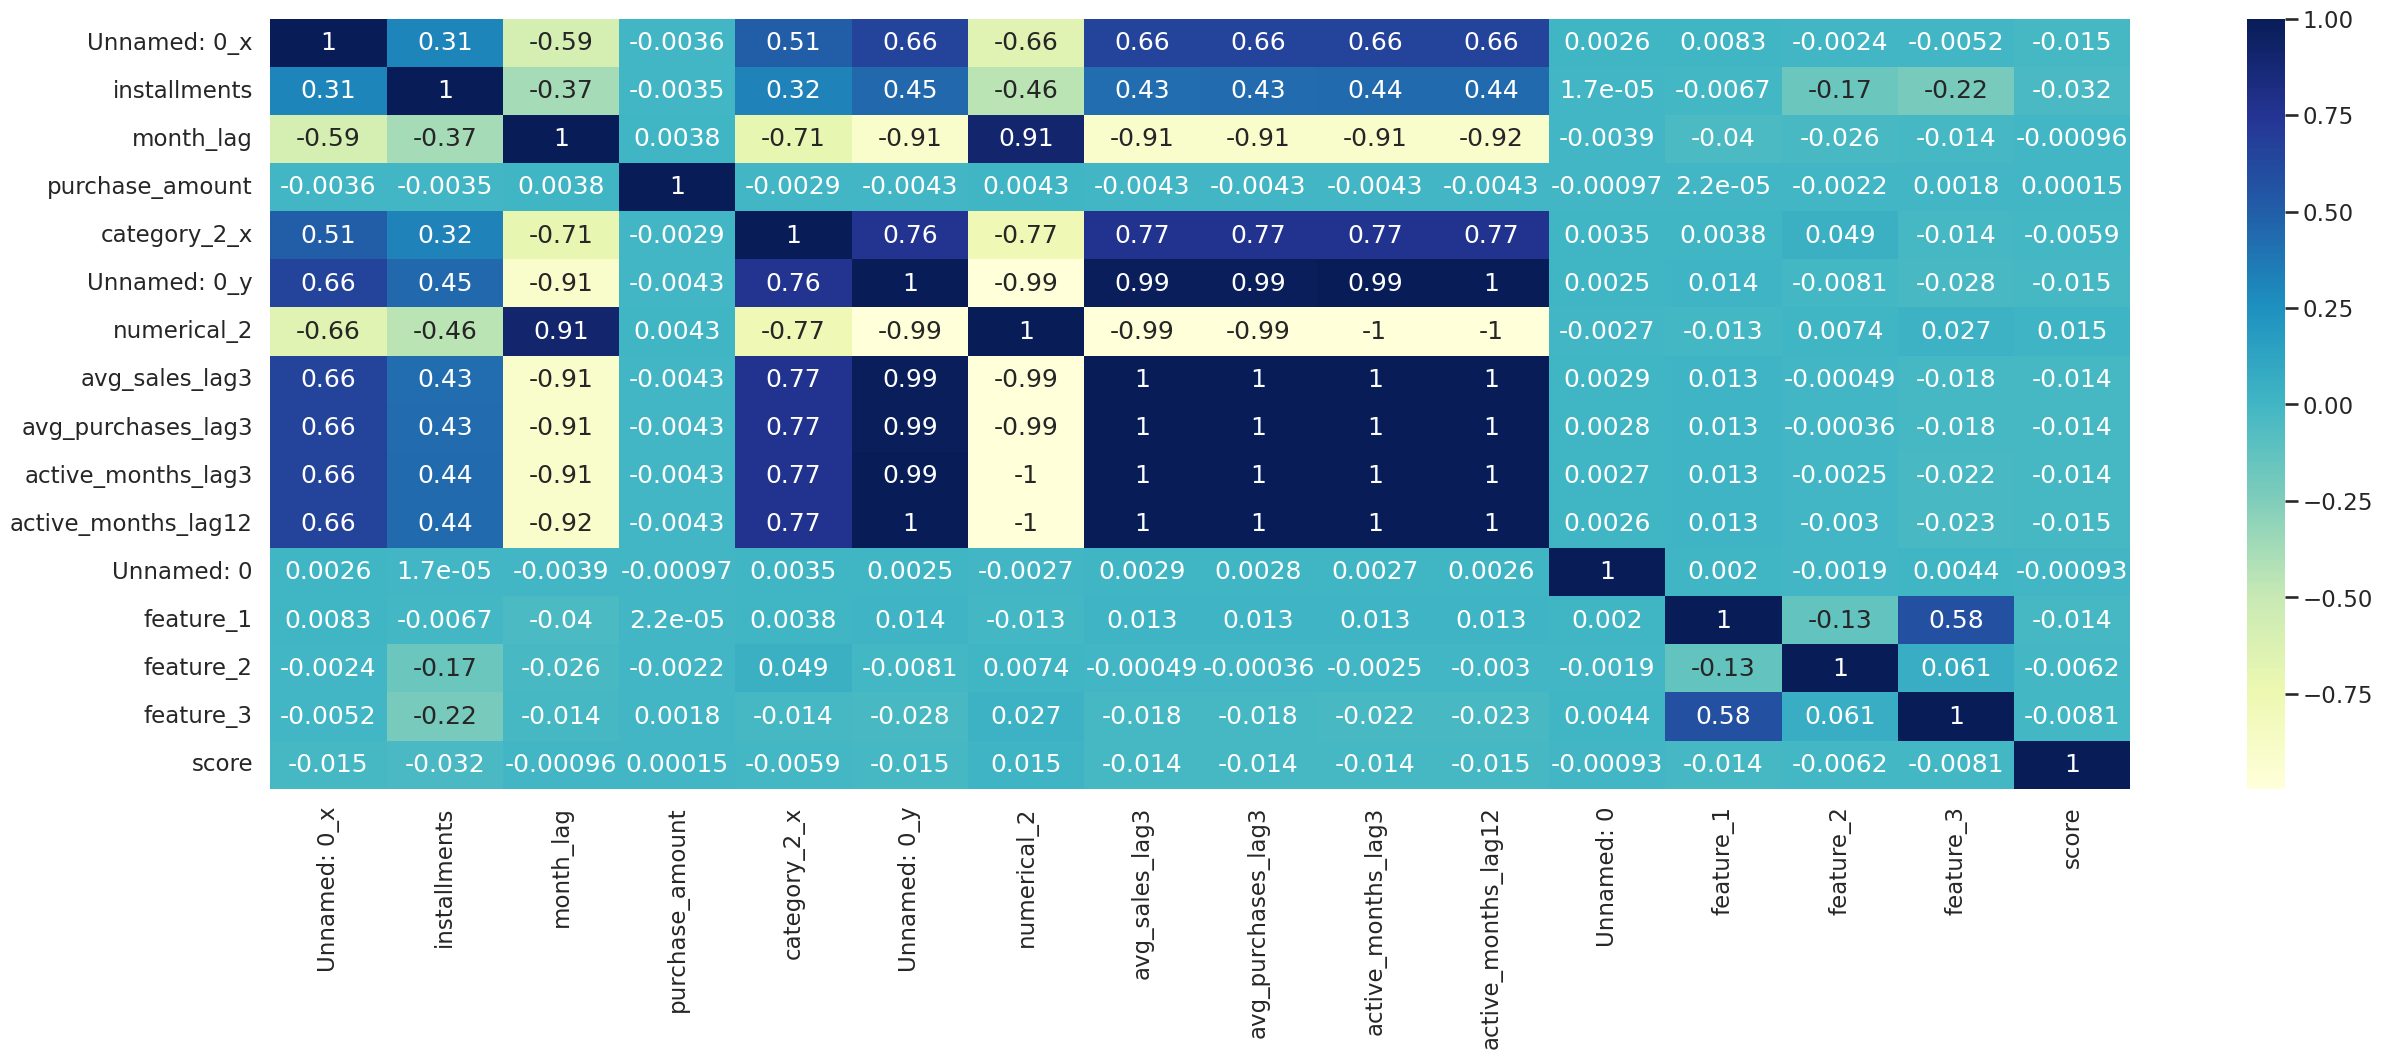

In [33]:
plt.figure(figsize = (30,10))
sns.heatmap(df_finall[num_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

In [34]:
# import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df_finall.dropna()
num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

,variable,VIF
0,Unnamed: 0_x,3.873843
1,installments,2.016530
2,month_lag,8.766632
3,purchase_amount,1.000025
4,category_2_x,3.661048
5,Unnamed: 0_y,335.273675
6,numerical_2,292.988091
7,avg_sales_lag3,4447.157176
8,avg_purchases_lag3,5699.980941
9,active_months_lag3,10710.959759


### Question 7 

> **Q7.** Detect if multicollinearity exists in selected features (used in Q6).

## Feature Extraction 

> **From above we can notice that there are high relation between active_months_lag12,active_months_lag3,avg_purchases_lag3,avg_sales_lag3 ,But i prefere not to drop them as it is understood that if the sales increased the purchase amount increase but in somtimes (not often ) the reverse may happend so i will try to not to drop them**

> **Some columns were in both transaction table and merchent table so i will drop one of them**

> **authorized_flag is 'Y' most of time but i will try not to drop it**

> **I will drop merchent id column as i not want the model to predict according to the features of the transaction not to the name of the merchent**

In [36]:
df_finall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0_x                 201917 non-null  int64  
 1   installments                 201917 non-null  int64  
 2   month_lag                    201917 non-null  int64  
 3   purchase_amount              201917 non-null  float64
 4   category_2_x                 201917 non-null  float64
 5   Unnamed: 0_y                 201917 non-null  int32  
 6   numerical_2                  201917 non-null  float64
 7   avg_sales_lag3               201917 non-null  float64
 8   avg_purchases_lag3           201917 non-null  float64
 9   active_months_lag3           201917 non-null  int64  
 10  active_months_lag12          201917 non-null  int64  
 11  authorized_flag              201917 non-null  object 
 12  city_id_x                    201917 non-null  object 
 13 

In [39]:
df_finall = df_finall.drop(['Unnamed: 0_x','Unnamed: 0','Unnamed: 0_y', 'subsector_id_x', 'state_id_x', 'merchant_category_id_x', 'category_1_x' ,'city_id_x' ,'category_2_x','merchant_id' ], axis=1)

### Question 6 

> **Q6.** Create a regression model for user loyalty score prediction based on the above analysis. You need to determine what features to use and which regression model to use.


> **We Will tru to use Linear Regression model , Ridge Model ,and lasso model**

> **From above we can see that the best feature for our model is :**

In [49]:
df_finall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   installments                 201917 non-null  int64  
 1   month_lag                    201917 non-null  int64  
 2   purchase_amount              201917 non-null  float64
 3   numerical_2                  201917 non-null  float64
 4   avg_sales_lag3               201917 non-null  float64
 5   avg_purchases_lag3           201917 non-null  float64
 6   active_months_lag3           201917 non-null  int64  
 7   active_months_lag12          201917 non-null  int64  
 8   authorized_flag              201917 non-null  object 
 9   category_3                   201917 non-null  object 
 10  purchase_date                201917 non-null  object 
 11  merchant_group_id            201917 non-null  object 
 12  merchant_category_id_y       201917 non-null  object 
 13 

### Question 4 

> **Q4.** Report important statistics in preprocessed data created in Q3. The target user loyalty score must be covered in the statistical analysis.

### **Check if the distribution of the data is Normal Distribution or not** 

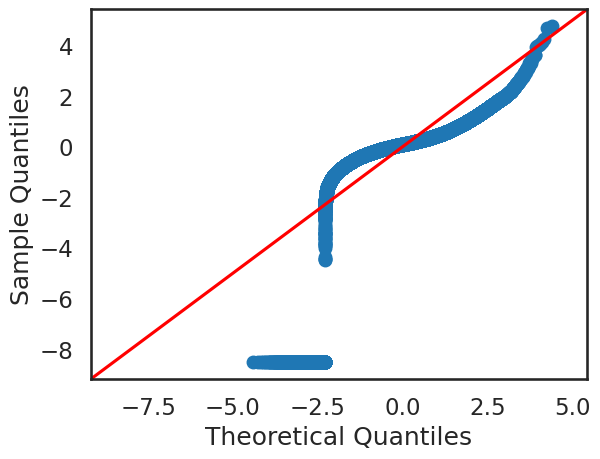

In [54]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(df_finall['score'], line='45', fit = True)
plt.show()

/tmp/ipykernel_99/1249615828.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_finall['score'], fit=norm, ax=axes[0])


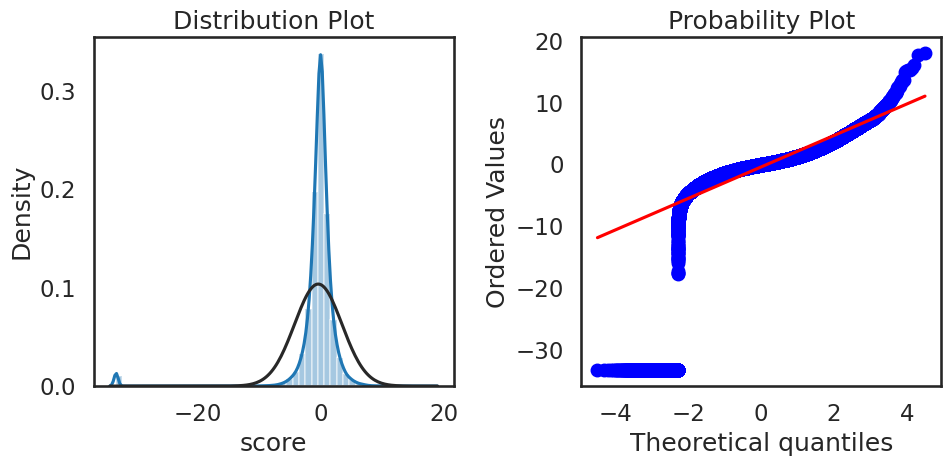

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(df_finall['score'], fit=norm, ax=axes[0])
axes[0].set_title('Distribution Plot')

stats.probplot(df_finall['score'], plot=axes[1])
plt.tight_layout()

## Encode Data

In [40]:
from category_encoders.binary import BinaryEncoder

encoder = BinaryEncoder()
encoder.fit(df_finall)
df_encoded = encoder.transform(df_finall)

## Split Data

In [41]:
predictors = list(df_encoded.columns)
predictors.remove('score')
X = pd.DataFrame(df_encoded[predictors])
y = df_encoded['score']

### Question 8 For Trial Two


> **Q8.** Build one regression model and report the performance of your model on train and test.

## Regression Model

In [42]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from math import log10
import sklearn.metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def creatRegression_Model(model , X, y):
    """
    Train and test a linear regression model using cross-validation.

    Parameters:
    -----------
    X : a pandas DataFrame of input features.
    y : a pandas Series of target values.

    Returns:
    --------
    None. Prints the cross-validation results, RMSE, and residual plots.
    """
    # Validate the input parameters
    assert isinstance(X, pd.DataFrame), "X must be a pandas DataFrame"
    assert isinstance(y, pd.Series), "y must be a pandas Series"

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    
    

    # Predict the target values on the training set
    y_train_pred = model.predict(X_train)

    # Calculate the RMSE for the training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    print("Train RMSE: {:.3f}".format(rmse_train))

    # Calculate the RMSE for test 
    # Predict the target values on the test set
    y_pred  = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Test RMSE: {:.3f}".format(rmse_test))
    

    # Generate predictions for the test data using the fitted model
    y_pred = model.predict(X_test)


    # Plot the results
    plt.scatter(y_test, y_pred, s=5, alpha=0.3)
    plt.xlabel('Real Score')
    plt.ylabel('Predicted Score')
    plt.title("Real vs Predicted Loyality Score")
    plt.show()

    plt.scatter(y_test, y_pred-y_test, s=5)
    plt.xlabel('Real Score')
    plt.ylabel('Residual')
    plt.title("Residuals vs Real")
    plt.show()
    
    
    features = X
    # Get the feature importances
    coefficients = model.coef_
    
    
    return model

Train RMSE: 3.866
Test RMSE: 3.765


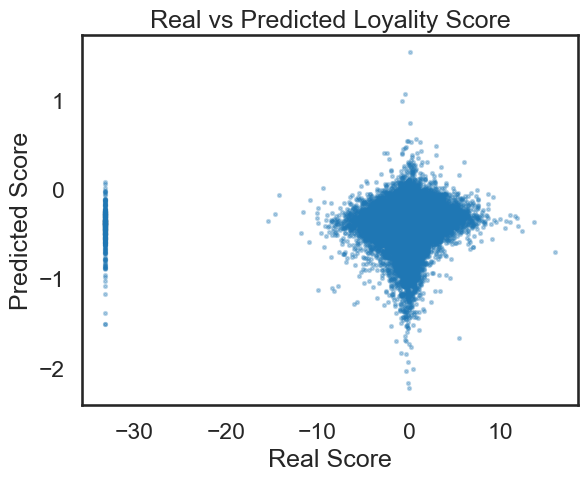

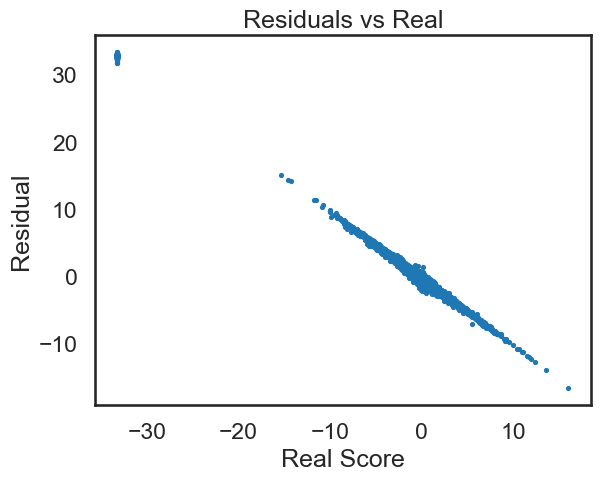

In [43]:
# First we will try to use Lasso Model
lasso = Lasso(alpha=1.0)
model = creatRegression_Model(lasso, X, y)

Train RMSE: 3.860
Test RMSE: 3.761


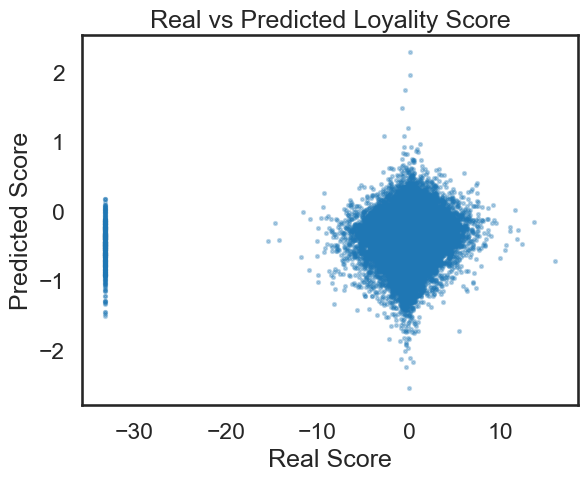

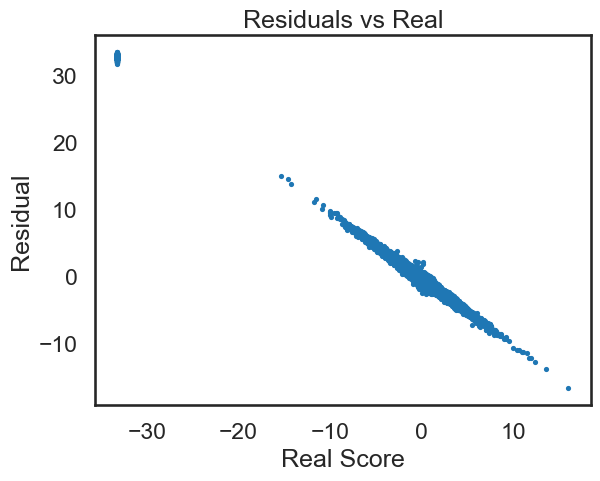

In [44]:
# Second we will try to use Ridge Model
ridge = Ridge(alpha=1.0)
model = creatRegression_Model(ridge, X, y)

Train RMSE: 3.860
Test RMSE: 3.761


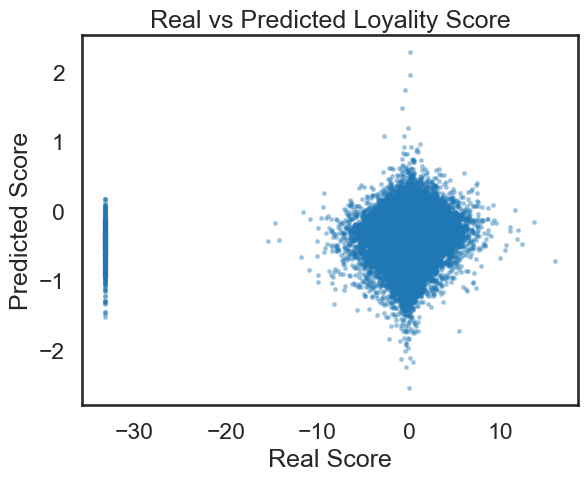

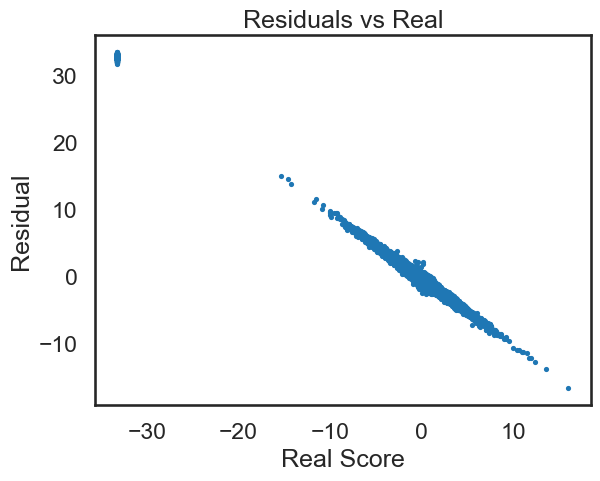

In [45]:
# Thired we will try to use Linear Regression Model
linear = LinearRegression( )
model = creatRegression_Model(linear, X, y)

# Trial Two 

## Join Data

In [5]:

result = pd.concat([df_new_merchant_trans, df_hist_trans])
## Here we will join (inner join) between all transaction data and user score data 
result2 = pd.merge(result, df_userscore, on='card_id')
## Here we will join (left join) between all transaction data and merchant data 
df = pd.merge(result2, df_merchant, on='merchant_id')


### Question 1  For Trial Two

> **Q1.** Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction. Note, this is a very important question, you may want to update your whole pipeline multiple times to find the best usage of three files.

To create a single data frame that merges all four tables, we will follow these steps:

1. Concatenate the historical and numerical transaction tables.
2. Inner merge the concatenated table with the user score table.
3. Left merge the resulting table with the merchant table.

In more detail, the first step will combine the historical and numerical transaction tables into a single table. The second step will then merge this table with the user score table, keeping only the rows that exist in both tables. The third step will then merge the resulting table with the merchant table, keeping all of the rows from the first table and adding any new rows from the merchant table.

This process will create a single data frame that contains all of the data from the four original tables. This data frame can then be used for further analysis or visualization.

### **Check if the distribution of the data is Normal Distribution or not** 

### Question 4 For Trial Two

> **Q4.** Report important statistics in preprocessed data created in Q3. The target user loyalty score must be covered in the statistical analysis.

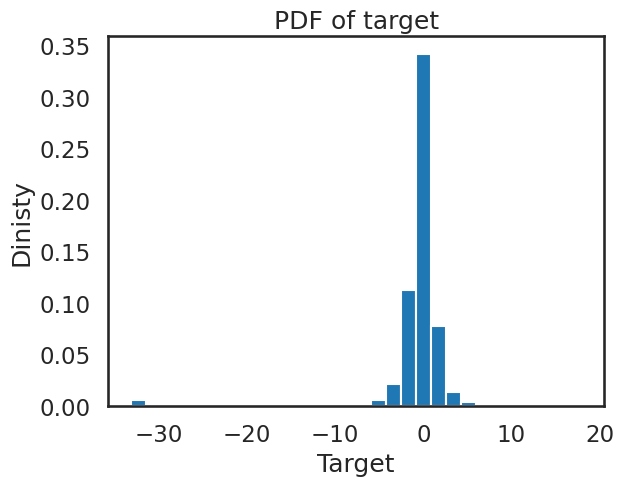

In [80]:
# generate a histogram of the 'age' column
fig = plt.hist(df['score'],density=True, bins=30)
x = plt.xlabel('Target')
x = plt.ylabel('Dinisty')
x = plt.title('PDF of target')
plt.show()

In [81]:
outliers_in_score= df.loc[df['score']< -30]
print(' The number of outliers in the data is:',outliers_in_score.shape[0])
non_outliers_in_score= df.loc[df['score'] >=-30]
print(' The number of non-outliers in the data is:',non_outliers_in_score.shape[0])

 The number of outliers in the data is: 194566
 The number of non-outliers in the data is: 19728870


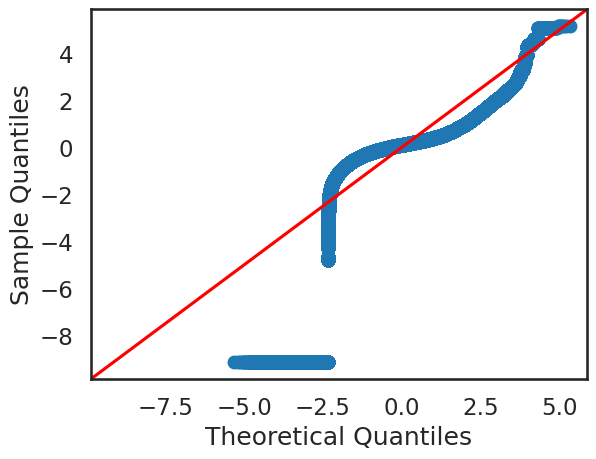

In [82]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(df['score'], line='45', fit = True)
plt.show()

/tmp/ipykernel_99/2382027977.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['score'], fit=norm, ax=axes[0])


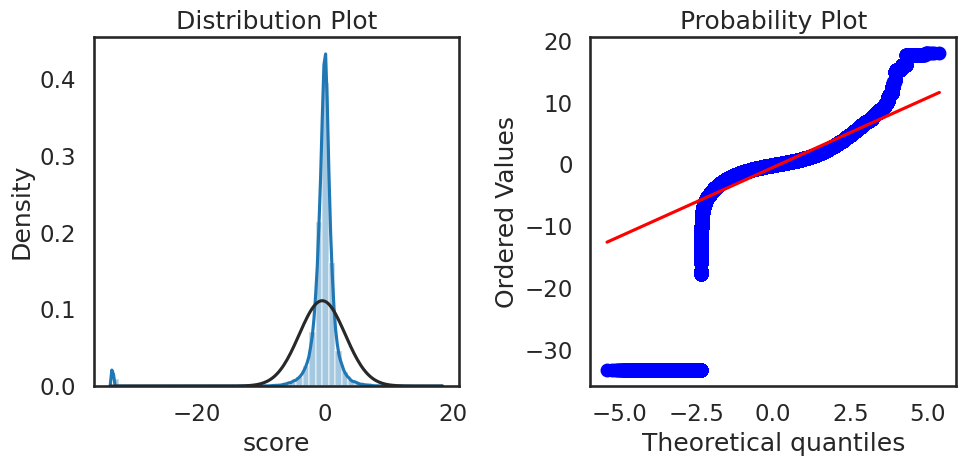

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(df['score'], fit=norm, ax=axes[0])
axes[0].set_title('Distribution Plot')

stats.probplot(df['score'], plot=axes[1])
plt.tight_layout()

### **Check Corrolation**

In [85]:
num_cols = df.select_dtypes(include=['int16','int8','int32','int64', 'float64']).columns.tolist()


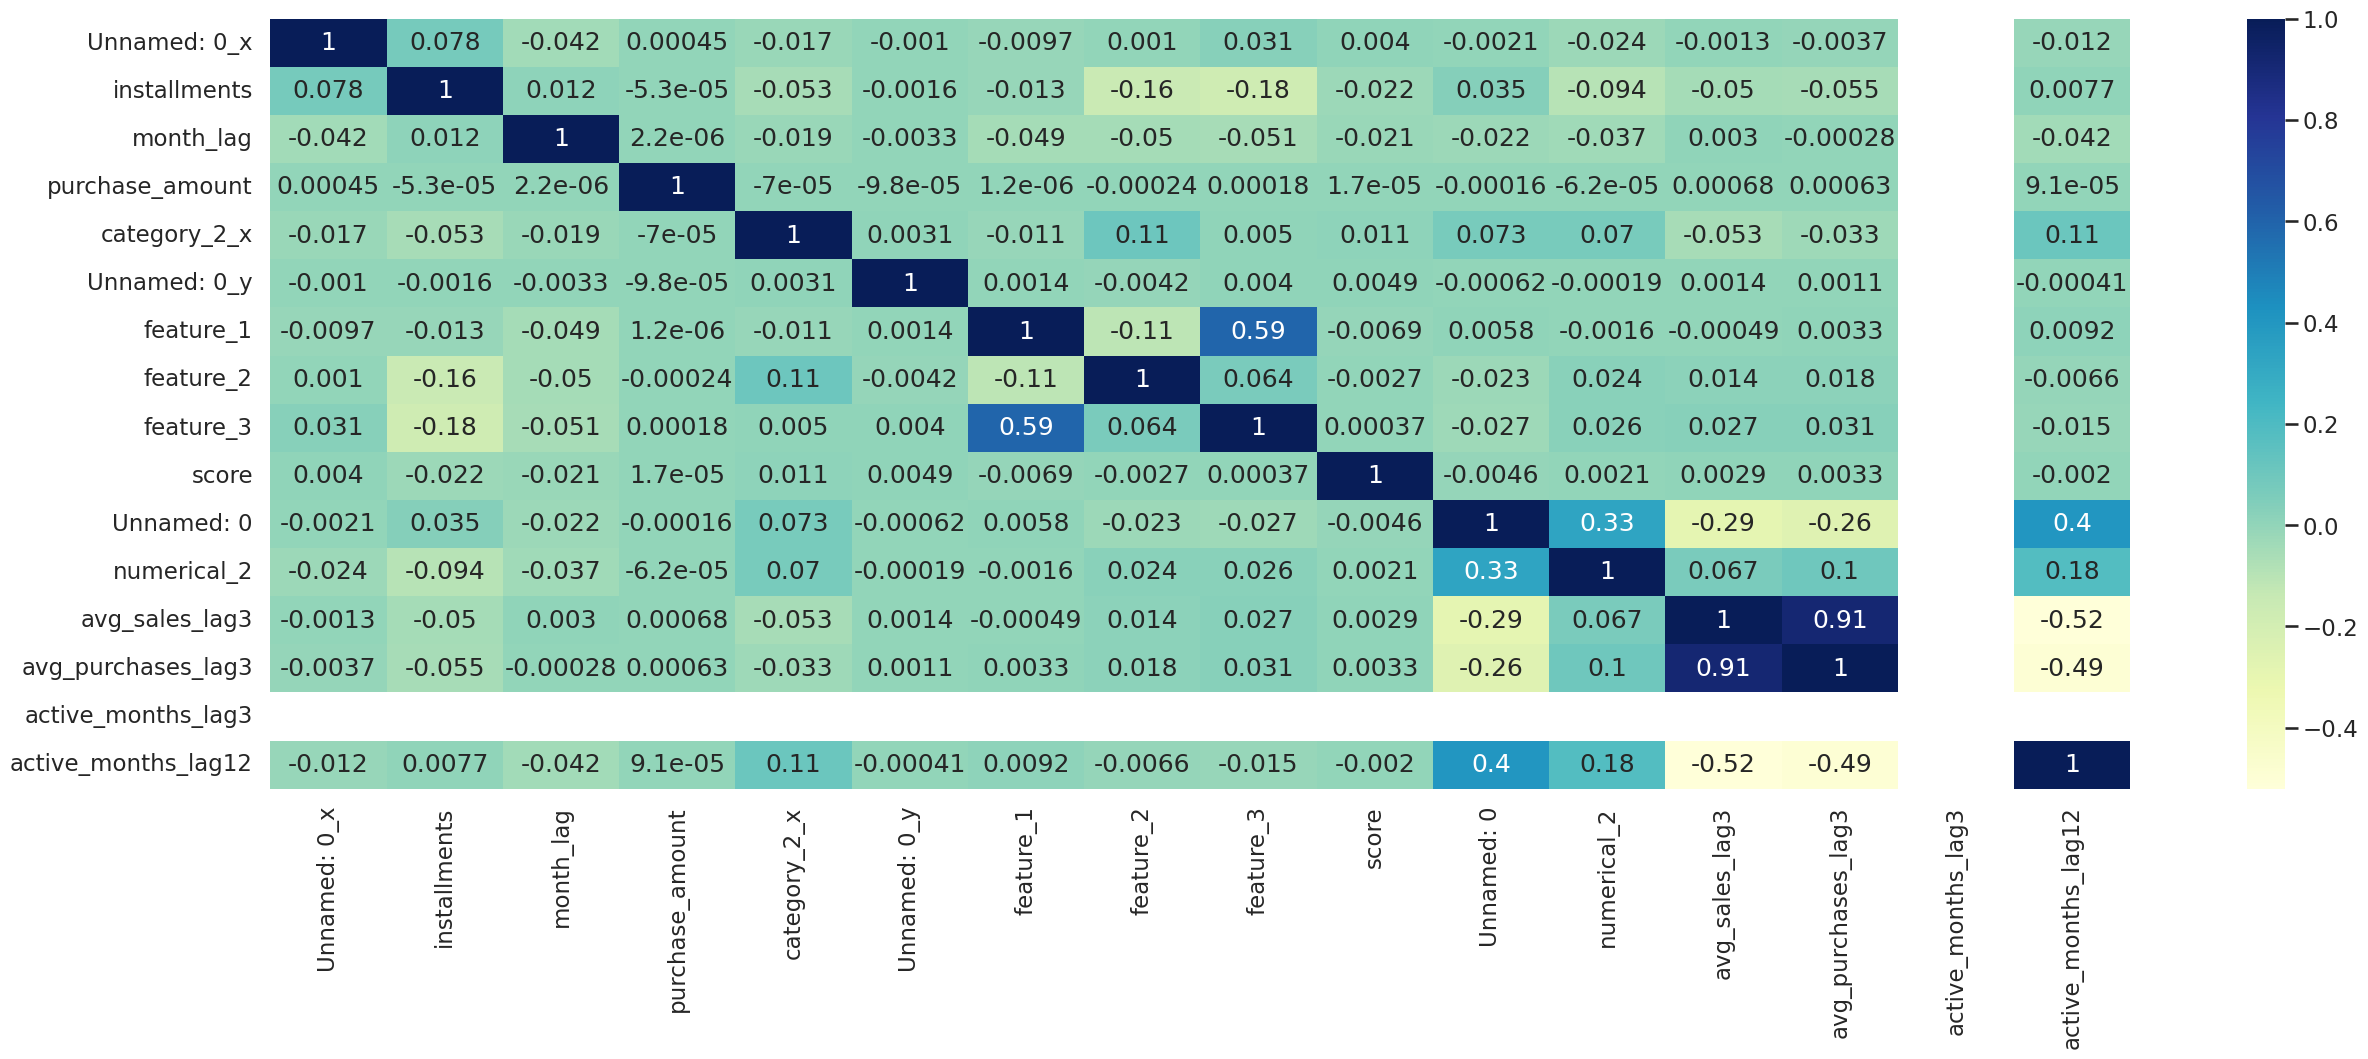

In [ ]:
plt.figure(figsize = (30,10))
sns.heatmap(df[num_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

In [90]:
target_corr = df[num_cols].corr()
target_corr['score'].sort_values(ascending=False)

score                  1.000000
category_2_x           0.010909
Unnamed: 0_y           0.004895
Unnamed: 0_x           0.003990
avg_purchases_lag3     0.003278
avg_sales_lag3         0.002867
numerical_2            0.002107
feature_3              0.000368
purchase_amount        0.000017
active_months_lag12   -0.002015
feature_2             -0.002746
Unnamed: 0            -0.004627
feature_1             -0.006888
month_lag             -0.020744
installments          -0.021535
active_months_lag3          NaN
Name: score, dtype: float64

In [9]:
# import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# drop null values from the DataFrame
data = df.dropna()
num_cols = data.select_dtypes('number').columns.tolist()

# calculate VIF values for each predictor variable
vif = pd.DataFrame()
vif['variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(data[num_cols].shape[1])]
vif

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variable,VIF
0,Unnamed: 0_x,1.012828
1,installments,1.089611
2,month_lag,1.011206
3,purchase_amount,1.000001
4,category_2_x,1.031149
5,Unnamed: 0_y,1.000093
6,feature_1,1.618664
7,feature_2,1.072075
8,feature_3,1.656835
9,score,1.001203


### Question 7 For Trial Two

> **Q7.** Detect if multicollinearity exists in selected features (used in Q6).

## Feature Extraction 

> **Here we will try another features to see th effect on the model**

> **From above we can notice that there are high relation between active_months_lag12,active_months_lag3,avg_purchases_lag3,avg_sales_lag3 ,I will try to drop them and i will leave only (active_months_lag12,avg_purchases_lag3)**

> **Some columns were in both transaction table and merchent table so i will drop one of them**

> **authorized_flag is 'Y' most of time but i will try to drop it**

> **I will drop merchent id column as i not want the model to predict according to the features of the transaction not to the name of the merchent**

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19923436 entries, 0 to 19923435
Data columns (total 37 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0_x                 int32  
 1   authorized_flag              object 
 2   card_id                      object 
 3   city_id_x                    object 
 4   category_1_x                 object 
 5   installments                 int8   
 6   category_3                   object 
 7   merchant_category_id_x       object 
 8   merchant_id                  object 
 9   month_lag                    int8   
 10  purchase_amount              float64
 11  purchase_date                object 
 12  category_2_x                 float64
 13  state_id_x                   object 
 14  subsector_id_x               object 
 15  Unnamed: 0_y                 int32  
 16  first_active_month           object 
 17  feature_1                    int8   
 18  feature_2                    int8   
 19

In [6]:
df = df.drop(['authorized_flag','active_months_lag3','avg_sales_lag3','Unnamed: 0_x','Unnamed: 0','Unnamed: 0_y', 'subsector_id_x', 'state_id_x', 'merchant_category_id_x', 'category_1_x' ,'card_id','city_id_x' ,'category_2_x','merchant_id' ], axis=1)

### Question 6 For Trial Two

> **Q6.** Create a regression model for user loyalty score prediction based on the above analysis. You need to determine what features to use and which regression model to use.


> **We Will tru to use Linear Regression model , Ridge Model ,and lasso model**

> **From above we can see that the best feature for our model is :**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19923436 entries, 0 to 19923435
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   installments                 int8   
 1   category_3                   object 
 2   month_lag                    int8   
 3   purchase_amount              float64
 4   purchase_date                object 
 5   first_active_month           object 
 6   feature_1                    int8   
 7   feature_2                    int8   
 8   feature_3                    int8   
 9   score                        float64
 10  merchant_group_id            object 
 11  merchant_category_id_y       object 
 12  subsector_id_y               object 
 13  numerical_2                  float64
 14  category_1_y                 object 
 15  most_recent_sales_range      object 
 16  most_recent_purchases_range  object 
 17  avg_purchases_lag3           float64
 18  active_months_lag12          int8   
 19

### Encode Categorical data 

In [8]:
from category_encoders.binary import BinaryEncoder

encoder = BinaryEncoder()
encoder.fit(df)
df_encoded = encoder.transform(df)

In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19923436 entries, 0 to 19923435
Columns: 102 entries, installments to category_2_y_2
dtypes: float64(4), int64(92), int8(6)
memory usage: 14.5 GB


### Split Data

In [10]:
predictors = list(df_encoded.columns)
predictors.remove('score')
X = pd.DataFrame(df_encoded[predictors])
y = df_encoded['score']

## Regression Model

### Question 8 For Trial Two


> **Q8.** Build one regression model and report the performance of your model on train and test.

Train RMSE: 3.588
Test RMSE: 3.576


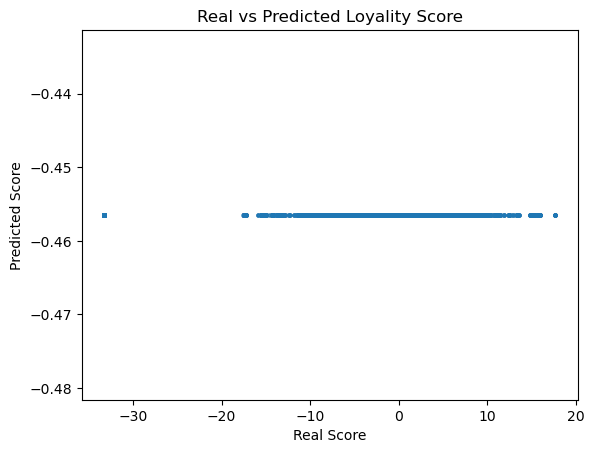

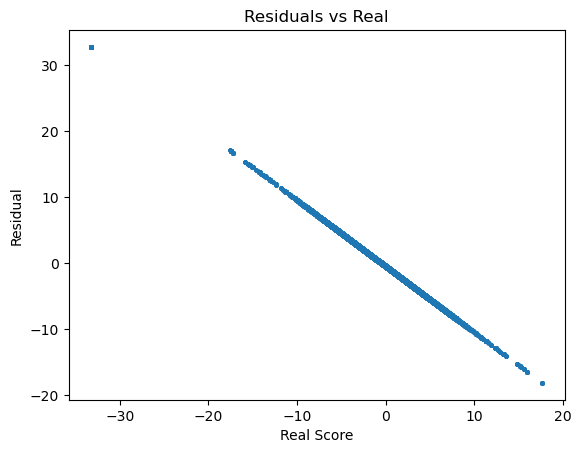

In [23]:
# First we will try to use Lasso Model
lasso = Lasso(alpha=1.0)
model = creatRegression_Model(lasso, X, y)

Train RMSE: 3.582
Test RMSE: 3.570


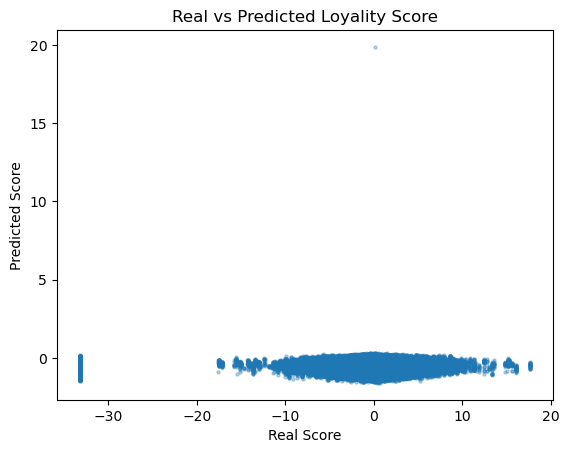

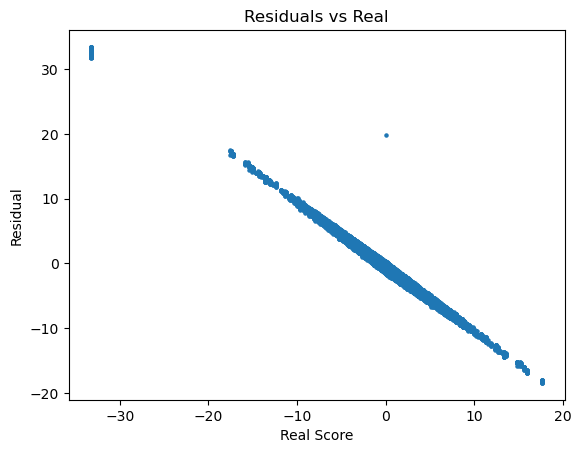

In [24]:
# Second we will try to use Ridge Model
ridge = Ridge(alpha=1.0)
model = creatRegression_Model(ridge, X, y)

Train RMSE: 3.582
Test RMSE: 3.570


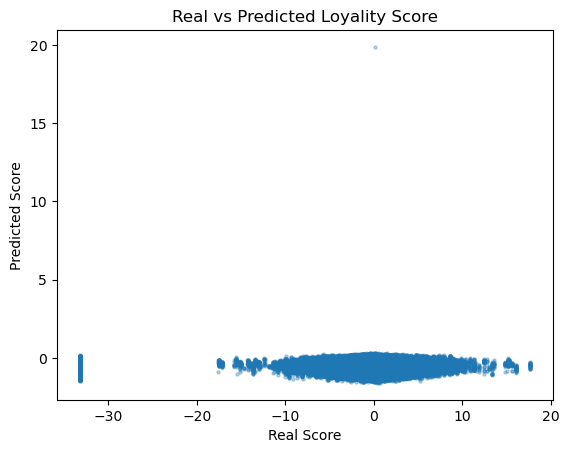

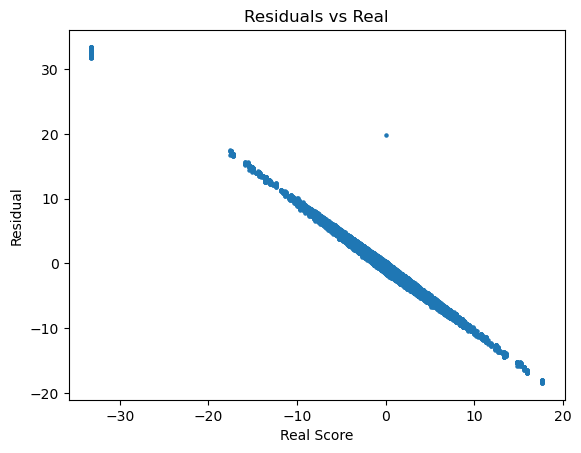

In [25]:
# Thired we will try to use Linear Regression Model
linear = LinearRegression( )
model = creatRegression_Model(linear, X, y)

Train RMSE: 3.588
Test RMSE: 3.576


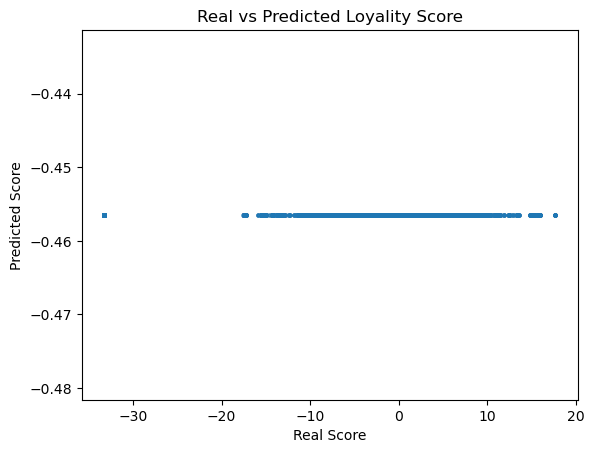

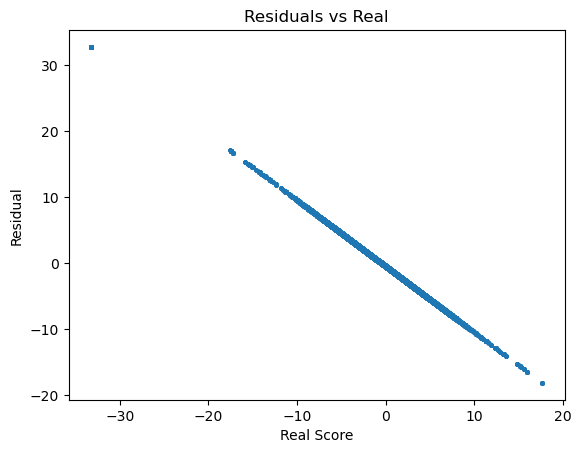

In [23]:
# First we will try to use Lasso Model
lasso = Lasso(alpha=1.0)
model = creatRegression_Model(lasso, X, y)

Train RMSE: 3.582
Test RMSE: 3.570


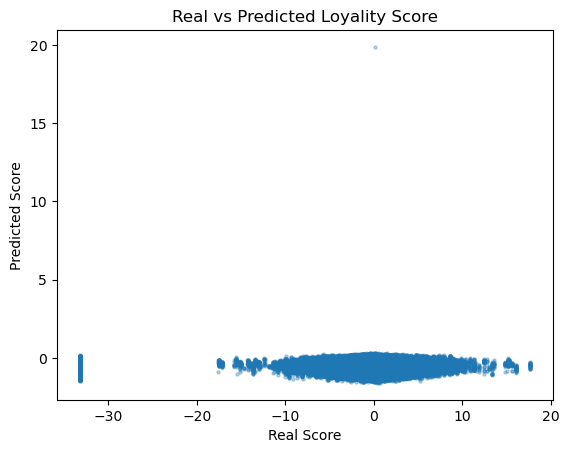

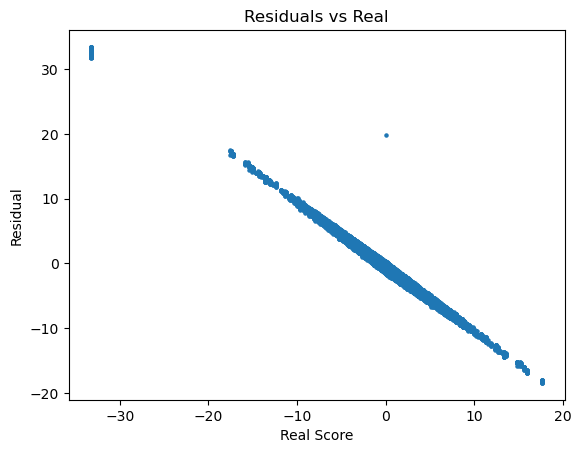

In [24]:
# Second we will try to use Ridge Model
ridge = Ridge(alpha=1.0)
model = creatRegression_Model(ridge, X, y)

Train RMSE: 3.582
Test RMSE: 3.570


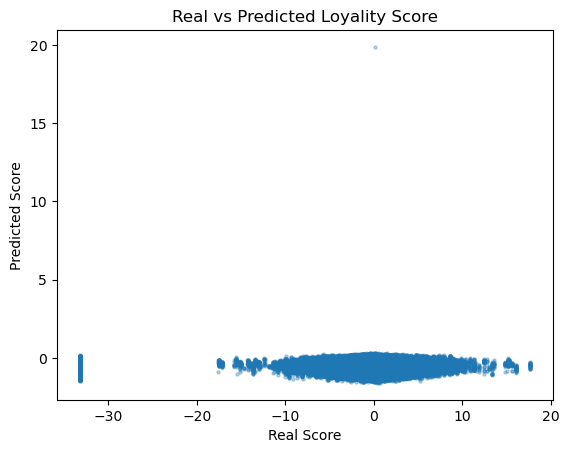

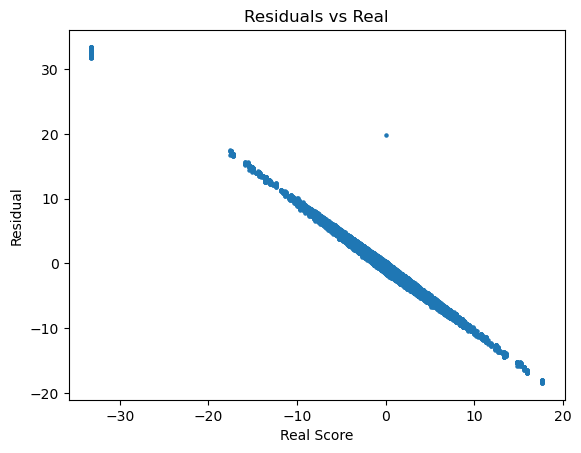

In [25]:
# Thired we will try to use Linear Regression Model
linear = LinearRegression( )
model = creatRegression_Model(linear, X, y)